In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import os
from sklearn import svm
from sklearn.model_selection import KFold
from io import StringIO
import tensorflow as tf



## Téléchargements fichiers

# Classification Automatique G-Quadruplexes

In [ ]:
g4_name = ["5yey","2lod","2lk7","2lby","2kpr","1xav","143d","2gku","2hy9","2jpz","2jsm","2kf8","2km3","2kyp","2lee","2lpw","2lxq","2m27","2m4p","2mgn","2n4y","6kfi","6kfj","1a8n","1emq","6zx6","1fqp","6zx7","139d","7cv3","7cv4","5oph","5nyu","5nys","5nyt","2l88","2kow","2a5p","2a5r"]

g4_topology = ["a","h","p","p","h","p","a","h","h","h","h","a","a","p","p","p","p","p","p","p","p"]

class guanine:
    def __init__(self,conformation,nb):
        self.conformation = conformation #anti = 1; syn = 0
        self.nb = nb

class G4:
    def __init__(self,tetrades,nb_mol,topo,bool):
        self.t = tetrades
        self.topologie = topo
        self.nb_mol = nb_mol
        self.diag_loop = bool

class g4_dict:
    def __init__(self,g4,name):
        self.name = name
        self.g4 = g4

## Observation des distances H1' - H8 pour trouver le bon cut off pour séparer syn et anti

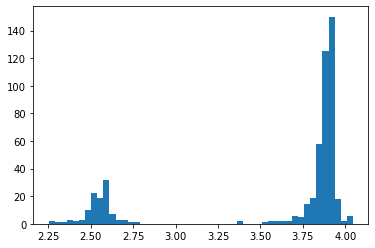

cut-off : 3.075641804556364


In [ ]:
def dist_h8(G):
    H8 = G.loc[ (G[2] == 'H8') ,6:8].values[0]            #On prend la position de H8
    H1p = G.loc[ (G[2] == 'H1\'') ,6:8].values[0]
    dist = np.linalg.norm(H8-H1p)
    return dist

def get_dist(name):
    text = urllib.request.urlopen('https://files.rcsb.org/view/'+name+'.pdb').read().decode()

    n_mol = 0

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+4]!= "ATOM":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)

    ind_end = ind_start
    bool = True
    while bool:
        n_mol +=1
        bool = False
        while text[ind_end:ind_end+3] != "TER":   #idem pour la fin du fichier
            ind_end = following_line(text,ind_end)
        f_l = following_line(text,ind_end)
        if text[f_l:f_l+4] == "ATOM":
            ind_end = f_l
            bool = True

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')


    nucleotid_number = []

    current_nb_base = 1
    last_nb_base = 1
    for k in range(len(data)):  #On résout le pb de repartir à la base n°1 si plusieurs molécules
        nb_base = data.iloc[k,5]
        if nb_base == current_nb_base + 1:
            current_nb_base += 1
            last_nb_base = nb_base
        elif nb_base < current_nb_base -1:
            if nb_base != last_nb_base:
                current_nb_base +=1
                last_nb_base = nb_base
                data.iloc[k,5] = current_nb_base
            else:
                data.iloc[k,5] = current_nb_base
    for k in range(len(data)):                 #on sélectionne les numéros de nucléotides correspondant à des G
        if data.iloc[k,3] == "DG":
            nb = data.iloc[k,5]
            if not nb in nucleotid_number:
                nucleotid_number.append(nb)

    dist_list = []


    for nb in nucleotid_number:
        G = data.loc[ data[5]== nb,:]
        dist = dist_h8(G)
        dist_list.append(dist)
    return dist_list


all_dist = []


for name in g4_name:
    dist = get_dist(name)
    all_dist = all_dist + dist

plt.figure()
plt.hist(all_dist,50)
plt.show()

# On peut donc prendre le milieu du max de la première gaussienne et du min de la deuxième

first_gauss = []
second_gauss = []

for d in all_dist:
    if d < 3:
        first_gauss.append(d)
    else:
        second_gauss.append(d)

cut_H1 = (np.max(first_gauss)+np.min(second_gauss))/2
print("cut-off : "+str(cut_H1))

def classication_syn_anti(G):    #Regarde la distance entre H8 et H1' qui est caractéristique de syn/anti
    H8 = G.loc[ (G[2] == 'H8') ,6:8].values[0]            #On prend la position de H8
    H1p = G.loc[ (G[2] == 'H1\'') ,6:8].values[0]
    dist = np.linalg.norm(H8-H1p)
    if dist>cut_H1:
        return 1  #anti
    else:
        return 0 #sin

## Observation des distances C5' -  N2 pour trouver le bon cut off pour séparer syn et anti (dans le cas de cristallo où les H ne sont pas représentés)

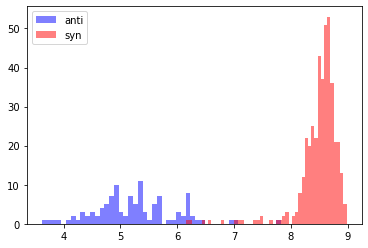

In [ ]:
def dist_n2(G):
    N2 = G.loc[ (G[2] == 'N2') ,6:8].values[0]            #On prend la position de H8
    C5p = G.loc[ (G[2] == 'C5\'') ,6:8].values[0]
    dist = np.linalg.norm(N2-C5p)
    return dist

def get_dist(name):
    text = urllib.request.urlopen('https://files.rcsb.org/view/'+name+'.pdb').read().decode()

    n_mol = 0

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+4]!= "ATOM":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)

    ind_end = ind_start
    bool = True
    while bool:
        n_mol +=1
        bool = False
        while text[ind_end:ind_end+3] != "TER":   #idem pour la fin du fichier
            ind_end = following_line(text,ind_end)
        f_l = following_line(text,ind_end)
        if text[f_l:f_l+4] == "ATOM":
            ind_end = f_l
            bool = True

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')

    nucleotid_number = []

    current_nb_base = 1
    last_nb_base = 1
    for k in range(len(data)):  #On résout le pb de repartir à la base n°1 si plusieurs molécules
        nb_base = data.iloc[k,5]
        if nb_base == current_nb_base + 1:
            current_nb_base += 1
            last_nb_base = nb_base
        elif nb_base < current_nb_base -1:
            if nb_base != last_nb_base:
                current_nb_base +=1
                last_nb_base = nb_base
                data.iloc[k,5] = current_nb_base
            else:
                data.iloc[k,5] = current_nb_base
    for k in range(len(data)):                 #on sélectionne les numéros de nucléotides correspondant à des G
        if data.iloc[k,3] == "DG":
            nb = data.iloc[k,5]
            if not nb in nucleotid_number:
                nucleotid_number.append(nb)

    dist_list_anti = []
    dist_list_syn = []


    for nb in nucleotid_number:
        G = data.loc[ data[5]== nb,:]
        dist = dist_n2(G)
        if classication_syn_anti(G):
            dist_list_syn.append(dist)
        else:
            dist_list_anti.append(dist)
    return dist_list_syn, dist_list_anti


all_dist_syn = []
all_dist_anti = []


for name in g4_name:
    syn, anti = get_dist(name)
    all_dist_syn = all_dist_syn + syn
    all_dist_anti = all_dist_anti + anti

plt.figure()
plt.hist(all_dist_anti,50,color = "blue", alpha = 0.5, label = 'anti')
plt.hist(all_dist_syn,50,color = "red", alpha = 0.5 , label = 'syn')
plt.legend()
plt.show()

Les 2 gaussiennes se chevauchent un peu, rajoutons une autre distance pour regarder si en 2D on peut clairement séparer

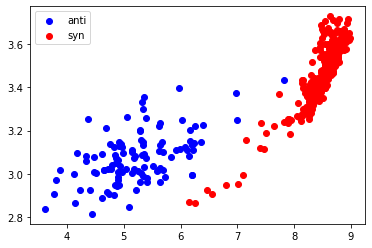

In [ ]:
def dist_c4(G):
    C4 = G.loc[ (G[2] == 'C4') ,6:8].values[0]            #On prend la position de H8
    O4p = G.loc[ (G[2] == 'O4\'') ,6:8].values[0]
    dist = np.linalg.norm(C4-O4p)
    return dist

def get_dist_2D(name):
    text = urllib.request.urlopen('https://files.rcsb.org/view/'+name+'.pdb').read().decode()

    n_mol = 0

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+4]!= "ATOM":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)

    ind_end = ind_start
    bool = True
    while bool:
        n_mol +=1
        bool = False
        while text[ind_end:ind_end+3] != "TER":   #idem pour la fin du fichier
            ind_end = following_line(text,ind_end)
        f_l = following_line(text,ind_end)
        if text[f_l:f_l+4] == "ATOM":
            ind_end = f_l
            bool = True

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')


    nucleotid_number = []

    current_nb_base = 1
    last_nb_base = 1
    for k in range(len(data)):  #On résout le pb de repartir à la base n°1 si plusieurs molécules
        nb_base = data.iloc[k,5]
        if nb_base == current_nb_base + 1:
            current_nb_base += 1
            last_nb_base = nb_base
        elif nb_base < current_nb_base -1:
            if nb_base != last_nb_base:
                current_nb_base +=1
                last_nb_base = nb_base
                data.iloc[k,5] = current_nb_base
            else:
                data.iloc[k,5] = current_nb_base
    for k in range(len(data)):                 #on sélectionne les numéros de nucléotides correspondant à des G
        if data.iloc[k,3] == "DG":
            nb = data.iloc[k,5]
            if not nb in nucleotid_number:
                nucleotid_number.append(nb)

    dist_list_anti = []
    dist_list_syn = []


    for nb in nucleotid_number:
        G = data.loc[ data[5]== nb,:]
        dist1 = dist_n2(G)
        dist2 = dist_c4(G)
        if classication_syn_anti(G):
            dist_list_syn.append([dist1,dist2])
        else:
            dist_list_anti.append([dist1,dist2])
    return dist_list_syn, dist_list_anti


all_dist_syn = []
all_dist_anti = []


for name in g4_name:
    syn, anti = get_dist_2D(name)
    all_dist_syn = all_dist_syn + syn
    all_dist_anti = all_dist_anti + anti




all_dist_syn = np.array(all_dist_syn)
all_dist_anti = np.array(all_dist_anti)


plt.figure()
plt.scatter(all_dist_anti[:,0],all_dist_anti[:,1],color="blue", label = 'anti')
plt.scatter(all_dist_syn[:,0],all_dist_syn[:,1],color="red", label = 'syn')
plt.legend()
plt.show()

Ici on a une séparation nette, on peut utiliser du svm pour séparer les 2 nuages de points.

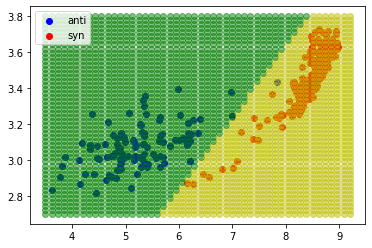

In [ ]:
X = np.concatenate((all_dist_anti,all_dist_syn))
Y = len(all_dist_anti)*[1] + len(all_dist_syn)*[0]

clf = svm.SVC(kernel = "linear",C=20,gamma=1)
clf.fit(X, Y)

xlist = np.linspace(3.5,9.2,50)
ylist = np.linspace(2.7,3.8,50)

test = []

for x in xlist:
    for y in ylist:
        test.append([x,y])

y = clf.predict(test)

plt.figure()
for k in range(len(test)):
    if y[k] == 1:
        plt.plot([test[k][0]],[test[k][1]],"g-o",alpha = 0.5)
    else:
        plt.plot([test[k][0]],[test[k][1]],"y-o",alpha = 0.5)
plt.scatter(all_dist_anti[:,0],all_dist_anti[:,1],color="blue", label = 'anti')
plt.scatter(all_dist_syn[:,0],all_dist_syn[:,1],color="red", label = 'syn')
plt.legend()
plt.show()

## Classification de la topologie d'un G-Quadruplex


On peut remarquer que la distance entre O6 d'un G et H1 d'un autre peut être discriminante pour savoir si les 2 G sont côte à côte dans la même tétrade. En effet, si la distance entre le O6 d'un G et le H1 d'un autre est plus petite qu'un certain seuil, on peut en déduire qu'ils sont côtes à côtes dans la même tétrade.

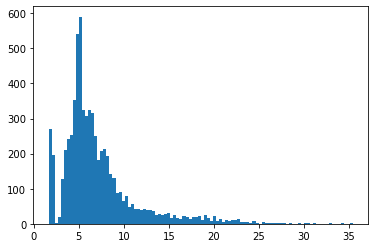

In [ ]:
def g_from_nb(g_list,nb):   #obtenir la class guanine à partir du nombre de base
    i = 0
    while g_list[i].nb != nb:
        i+=1
    return g_list[i]




def G_dist(name):

    text = urllib.request.urlopen('https://files.rcsb.org/view/'+name+'.pdb').read().decode()

    n_mol = 0

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+4]!= "ATOM":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)

    ind_end = ind_start
    bool = True
    while bool:
        n_mol +=1
        bool = False
        while text[ind_end:ind_end+3] != "TER":   #idem pour la fin du fichier
            ind_end = following_line(text,ind_end)
        f_l = following_line(text,ind_end)
        if text[f_l:f_l+4] == "ATOM":
            ind_end = f_l
            bool = True

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')


    nucleotid_number = []

    current_nb_base = 1
    last_nb_base = 1
    for k in range(len(data)):  #On résout le pb de repartir à la base n°1 si plusieurs molécules
        nb_base = data.iloc[k,5]
        if nb_base == current_nb_base + 1:
            current_nb_base += 1
            last_nb_base = nb_base
        elif nb_base < current_nb_base -1:
            if nb_base != last_nb_base:
                current_nb_base +=1
                last_nb_base = nb_base
                data.iloc[k,5] = current_nb_base
            else:
                data.iloc[k,5] = current_nb_base
    for k in range(len(data)):                 #on sélectionne les numéros de nucléotides correspondant à des G
        if data.iloc[k,3] == "DG":
            nb = data.iloc[k,5]
            if not nb in nucleotid_number:
                nucleotid_number.append(nb)
    anti = 0
    syn = 0

    guanine_list = []

    for nb in nucleotid_number:
        G = data.loc[ data[5]== nb,:]
        classe = classication_syn_anti(G)
        g = guanine(classe,nb)
        guanine_list.append(g)

    dist_list = []

    for nb1 in nucleotid_number:
        for nb2 in nucleotid_number:
            if nb1 != nb2:
                O6 = data.loc[ (data[2] == 'O6') & (data[5] == nb1) ,6:8].values[0]  #distance O6-H1 caractéristique du fait d'être côte à côte
                H1 = data.loc[ (data[2] == 'H1') & (data[5] == nb2),6:8].values[0]
                dist_list.append(np.linalg.norm(O6-H1))
    return dist_list

all_dist = []
for name in g4_name:
    all_dist += G_dist(name)

plt.figure()
plt.hist(all_dist, bins = 100)
plt.show()



On aperçoit un premier pic suivi d'une gaussienne, zoomons sur le premier pic pour mieux comprendre où se situe le seuil.

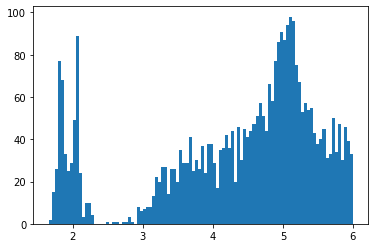

In [ ]:
all_dist_zoom = []
for d in all_dist:
    if d<6:
        all_dist_zoom.append(d)

plt.figure()
plt.hist(all_dist_zoom, bins = 100)
plt.show()


On voit que vers 2.3, une séparation semble apparître, calculons le milieu entre la première et la deuxième gaussienne.

In [ ]:
all_dist_zoom = np.sort(all_dist_zoom)
longer_dist = 0  #On regarde à quel moment on a ce gap
ind_longer = 0
for k in range(len(all_dist_zoom)-1):
    dist = all_dist_zoom[k+1]-all_dist_zoom[k]
    if dist >longer_dist:
        longer_dist = dist
        ind_longer = k

print("Le plus grand gap est entre les distances  "+str(all_dist_zoom[ind_longer])+" et "+str(all_dist_zoom[ind_longer+1]))

cut_O6 = (all_dist_zoom[ind_longer] + all_dist_zoom[ind_longer+1])/2

print("\n On choisit le cut-off "+str(cut_O6))

Le plus grand gap est entre les distances  2.2797451611967507 et 2.4980596470060545

 On choisit le cut-off 2.388902404101403


## On peut maintenant écrire l'algorithme de prédiction de topologie

In [ ]:

def g_from_nb(g_list,nb):   #obtenir la class guanine à partir du nombre de base
    i = 0
    while g_list[i].nb != nb:
        i+=1
    return g_list[i]




def build_g4(name):

    text = urllib.request.urlopen('https://files.rcsb.org/view/'+name+'.pdb').read().decode()

    n_mol = 0

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+4]!= "ATOM":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)

    ind_end = ind_start
    bool = True
    while bool:
        n_mol +=1
        bool = False
        while text[ind_end:ind_end+3] != "TER":   #idem pour la fin du fichier
            ind_end = following_line(text,ind_end)
        f_l = following_line(text,ind_end)
        if text[f_l:f_l+4] == "ATOM":
            ind_end = f_l
            bool = True

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')


    nucleotid_number = []

    current_nb_base = 1
    last_nb_base = 1
    for k in range(len(data)):  #On résout le pb de repartir à la base n°1 si plusieurs molécules
        nb_base = data.iloc[k,5]
        if nb_base == current_nb_base + 1:
            current_nb_base += 1
            last_nb_base = nb_base
        elif nb_base < current_nb_base -1:
            if nb_base != last_nb_base:
                current_nb_base +=1
                last_nb_base = nb_base
                data.iloc[k,5] = current_nb_base
            else:
                data.iloc[k,5] = current_nb_base
    for k in range(len(data)):                 #on sélectionne les numéros de nucléotides correspondant à des G
        if data.iloc[k,3] == "DG":
            nb = data.iloc[k,5]
            if not nb in nucleotid_number:
                nucleotid_number.append(nb)
    anti = 0
    syn = 0

    guanine_list = []

    for nb in nucleotid_number:
        G = data.loc[ data[5]== nb,:]
        classe = classication_syn_anti(G)
        g = guanine(classe,nb)
        guanine_list.append(g)

    tetrades_list = []
    tetrades_g_list = []
    numbers = len(nucleotid_number) * [0] #On regarde les numéros de G qui sont déjà dans un tetrade
    ones = len(nucleotid_number)*[1]
    while numbers != ones:
        tetrade = []
        tetrade_g = []
        i = 0
        while numbers[i]==1: #on prend le premier numéro qui n'est pas déjà traité
            i+=1
        indexs = [i]
        O6 = data.loc[ (data[2] == 'O6') & (data[5] == nucleotid_number[i]) ,6:8].values[0]  #distance O6-H1 caractéristique du fait d'être côte à côte
        H1 = data.loc[ (data[2] == 'H1') & (data[5] == nucleotid_number[i]),6:8].values[0]
        tetrade.append(nucleotid_number[i])
        tetrade_g.append(g_from_nb(guanine_list,nucleotid_number[i]))
        bool = True
        while bool and len(tetrade)<4:
            bool = False  #regarde si on a ajouté un autre G à la tetrade en cours
            for k in range(len(nucleotid_number)):
                if (not nucleotid_number[k] in tetrade) and numbers[k]==0:
                    O6bis = data.loc[ (data[2] == 'O6') & (data[5] == nucleotid_number[k]) ,6:8].values[0]
                    H1bis = data.loc[ (data[2] == 'H1') & (data[5] == nucleotid_number[k]),6:8].values[0]
                    if np.linalg.norm(O6bis - H1) < 2.5 or np.linalg.norm(O6 - H1bis) < cut_O6:
                        tetrade.append(nucleotid_number[k])
                        tetrade_g.append(g_from_nb(guanine_list,nucleotid_number[k]))
                        bool = True
                        indexs.append(k)
                        O6 = O6bis
                        H1 = H1bis
        for x in indexs:
            numbers[x] =  1
        if len(tetrade)>3:
            tetrades_list.append(tetrade)
            tetrades_g_list.append(tetrade_g)
    t1,t2 = tetrades_list[0],tetrades_list[1]    #bmrb
    up = 0
    down = 0
    diag_loop = False
    for i in range(len(t1)-1):
        if t1[i]>t1[i+1]:
            diag_loop = True
            continue
    for i in range(len(t1)):
        if t1[i]<t2[i]:
            up+=1
        else:
            down+=1
    if up == 0 or down == 0:
        ratio = 10  #parallel
    else:
        ratio = np.max([up/down,down/up])
    if ratio == 10:
        topo = "parallel"
    elif ratio == 1:
        topo = "antiparallel"
    else:
        topo = "hybrid"
    return G4(tetrades_g_list,n_mol,topo,diag_loop)



def Topologie(name):
    quad = build_g4(name)
    t_list = quad.t
    for i in range(len(t_list)):
        print("\n Tétrade "+str(i+1)+" : ")
        for g in t_list[i]:
            if g.conformation == 1:
                conf = "anti"
            else:
                conf = "syn"
            print(str(int(g.nb))+" ("+conf+")   ")
    nmol = quad.nb_mol
    if nmol == 1:
        type = "monomeric"
    elif nmol == 2:
        type = "dimeric"
    elif nmol == 3:
        type = "trimeric"
    else:
        type = "tetrameric"
    print("\n => "+quad.topologie+ "  ("+type+")")
    if quad.diag_loop and nmol ==1 :
        print("\n There is a diagonal loop")


Testons sur une petite base de donnée

In [ ]:
n = len(g4_topology)

for k in range(n):
    name = g4_name[k]
    Topologie(name)
    print("real topology : "+g4_topology[k])


 Tétrade 1 : 
1 (syn)   
9 (anti)   
13 (syn)   
21 (anti)   

 Tétrade 2 : 
2 (anti)   
8 (syn)   
14 (anti)   
20 (syn)   

 Tétrade 3 : 
3 (anti)   
7 (syn)   
15 (anti)   
19 (syn)   

 => antiparallel  (monomeric)
real topology : a

 Tétrade 1 : 
1 (syn)   
6 (syn)   
20 (syn)   
16 (anti)   

 Tétrade 2 : 
2 (anti)   
7 (anti)   
21 (anti)   
15 (syn)   

 Tétrade 3 : 
3 (anti)   
8 (anti)   
22 (anti)   
14 (syn)   

 => hybrid  (monomeric)

 There is a diagonal loop
real topology : h

 Tétrade 1 : 
3 (anti)   
7 (anti)   
11 (anti)   
15 (anti)   

 Tétrade 2 : 
4 (anti)   
8 (anti)   
12 (anti)   
16 (anti)   

 Tétrade 3 : 
5 (anti)   
9 (anti)   
13 (anti)   
17 (anti)   

 => parallel  (monomeric)
real topology : p

 Tétrade 1 : 
3 (anti)   
7 (anti)   
12 (anti)   
16 (anti)   

 Tétrade 2 : 
4 (anti)   
8 (anti)   
13 (anti)   
17 (anti)   

 Tétrade 3 : 
5 (anti)   
9 (anti)   
14 (anti)   
18 (anti)   

 => parallel  (monomeric)
real topology : p

 Tétrade 1 : 
1 (syn)

L'algorithme fonctionne sur notre petit dataset.

# Déplacements chimiques

Maintenant nous devons importer et traiter les données de déplacements chimiques. Malheureusement, sur PDB on n'a pas les déplacements chimiques pour tous les G-Quadruplexes. De plus, notre classificateur de topologie peut ne pas marcher sur des G4 spéciaux. On doit donc faire le tri.

In [ ]:
all_g4 = "7CLS, 1XAV, 6H1K, 6KFI, 6KFJ, 1A8N, 1A6H, 6FC9, 2M4P, 2M27, 6ZL2, 6ZL9, 6ZTE, 2KAZ, 2HY9, 2KKA, 1MYQ, 2LBY, 1I34, 1A8W, 1JVC, 2JT7, 1U64, 5Z8F, 1NZM, 1AFF, 2MB3, 1JJP, 2L7V, 2F8U, 5OPH, 2N4Y, 2KYO, 2KYP, 7CV4, 7CV3, 6AC7, 139D, 6ZX7, 5Z80, 2MB2, 1FQP, 6ZX6, 2LD8, 6R9L, 6R9K, 1EMQ, 2KPR, 2MBJ, 2N2D, 5NYU, 5NYS, 5NYT, 2AQY, 2JPZ, 5MVB, 5MCR, 2KOW, 5MBR, 6IA4, 6IA0, 6JCD, 2A5P, 2A5R, 2JWQ, 7ATZ, 6SX3, 1C32, 1C34, 2LOD, 6JCE, 1C35, 1C38, 2MB4, 7O1H, 1NP9, 1QDF, 1QDI, 6K3Y, 6K3X, 6F4Z, 5YEY, 2KZD, 2KZE, 2KQG, 2KQH, 6A7Y, 1K4X, 6CCW, 2N9Q, 5ZEV, 1LVS, 2M6V, 6GH0, 6ZRM, 2M6W, 156D, 6YY4, 5OV2, 2MGN, 2AKG, 2M1G, 2KM3, 6NEB, 2CHK, 2LED, 2LEE, 5LIG, 2CHJ, 5O4D, 2M53, 2MCO, 6RS3, 6JWD, 2MS6, 6JWE, 2M8Z, 2M90, 2M91, 2M92, 2M93, 7CPS, 5J6U, 1QDH, 1QDK, 2WCN, 5J05, 6ERL, 2LYG, 2KVY, 2LXV, 6KVB, 7CSK, 6LNZ, 6YEP, 2LXQ, 5MJX, 6GZN, 2KF8, 6YCV, 2LE6, 2GKU, 6V0L, 2KF7, 2MWZ, 2E4I, 2O3M, 1Y8D, 2N3M, 2MFT, 2MFU, 2MS9, 5W77, 5MTA, 5MTG, 5I2V, 6IMS, 1RDE, 6KXZ, 5J4W, 5J4P, 2LK7, 2K90, 2K8Z, 2K97, 2N6C, 7E5P, 7NWD, 1NYD, 2HK4, 2LPW, 2MCC, 1OZ8, 6L92, 1XCE, 7KBV, 6T51, 6O2L, 6JJ0, 7KBX, 7KBW, 2N21, 7D5F, 6SYK, 6SX6, 1EVO, 2LSX, 2N60, 6TCG, 6TC8, 5M2L, 5M1L, 5M4W, 6L8M, 1EEG, 1EU2, 1EU6, 2MAY, 2M8Y, 2JSL, 2JSM, 230D, 2JSK, 2JSQ, 1N96, 1F3S, 5LQG, 5LQH, 6T2G, 6SUU, 1X0F, 1WTB, 143D, 2IDN, 148D, 1EVM, 1EVN, 6TR2, 1D6D"

data_g4 = pd.read_fwf(StringIO(all_g4),delimiter = ", ", header = None).values

good_g4 = []
bad_g4 = []


for k in range (len(data_g4[0])):
    print(k)
    name = str(data_g4[0][k])
    try:
        text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()
        quad = build_g4(name)
        good_g4.append(name)
    except (urllib.error.HTTPError, IndexError):
        bad_g4.append(name)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218


## Traitement des fichiers de déplacement chimique

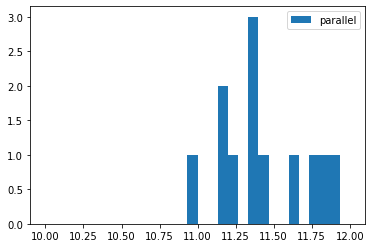

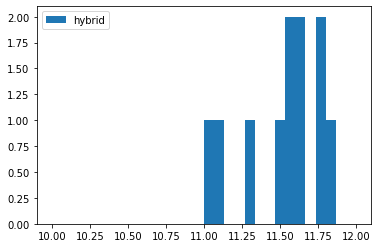

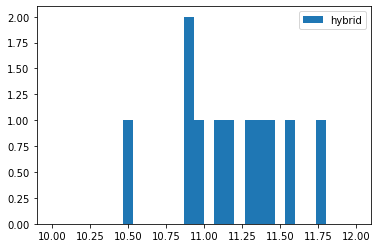

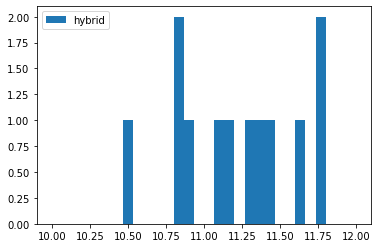

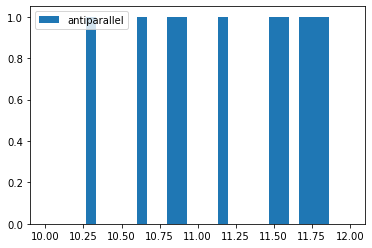

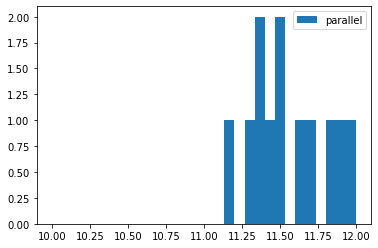

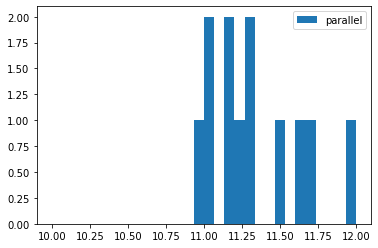

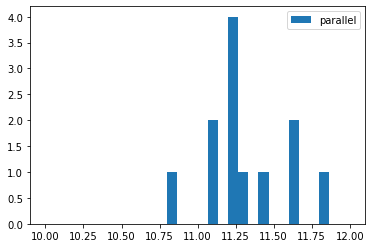

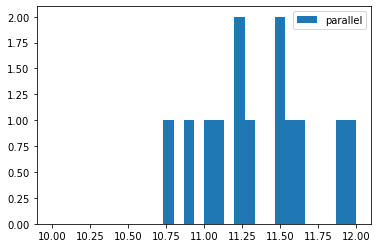

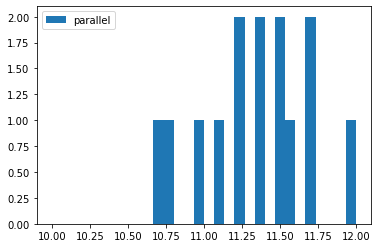

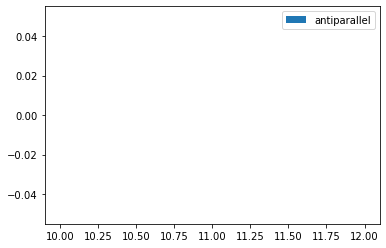

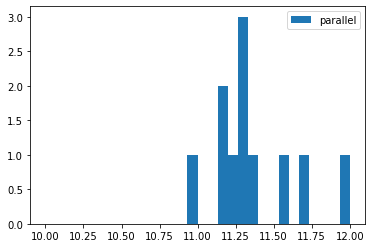

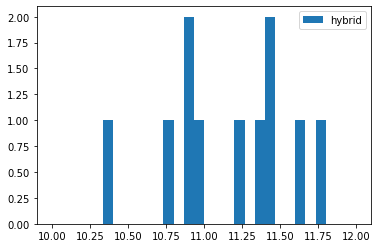

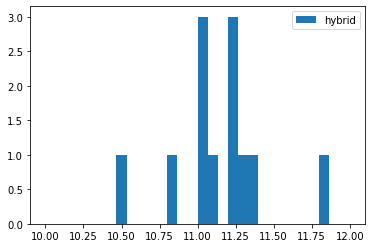

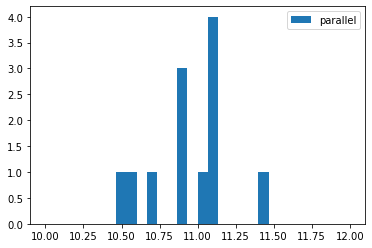

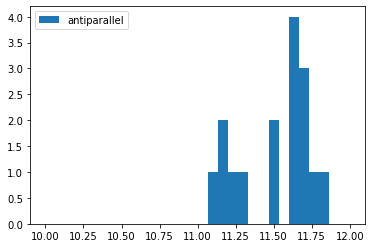

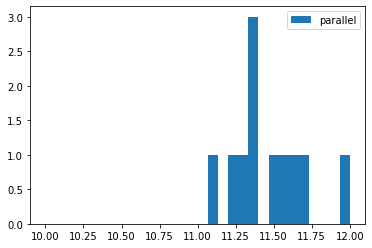

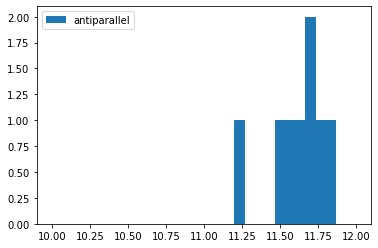

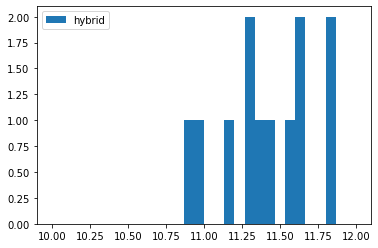

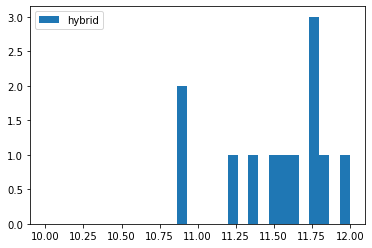

In [ ]:
def spectre(name):
    text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+44]!= "_Atom_chem_shift.Assigned_chem_shift_list_ID":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)

    ind_start = following_line(text,ind_start)

    ind_end = ind_start
    while text[ind_end:ind_end+5]!= "stop_":
        ind_end = following_line(text,ind_end)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')

    peaks = []

    quad = build_g4(name)

    #n_atoms = []                 #On sélectionne les déplacements chimiques seulement dans les tétrades
    #t = quad.t
    #for x in t:
     #   for y in x:
      #      n_atoms.append(y.nb)



    for k in range(len(data)):
        #if data.iloc[k,3] in n_atoms:
        peak = data.iloc[k,9]
        if 10< peak and peak < 13:   #On s'intéresse qu'a cette tranche pour l'instant
            peaks.append(data.iloc[k,9])

    peaks = np.array(peaks)

    type = quad.topologie

    plt.figure()
    plt.hist(peaks,bins = 30, range = (10,12),label = type)
    plt.legend()
    plt.show()

for name in good_g4[:20]:
    spectre(name)

In [ ]:
good_g4[16]

'2N4Y'

Avant de commencer l'apprentissage pour classifier les spectres RMN, il est important de connaître les proportions de chaque classe.

In [ ]:
good_g4[24]

'2LD8'

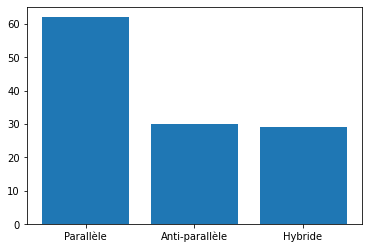

In [ ]:
p_count = 0
a_count = 0
h_count = 0

label_g4=[]   # parallele = 0 ; antiparallele = 1 ; hybride = 2

for name in good_g4:
    quad = build_g4(name)
    topo = quad.topologie
    if topo == "parallel":
        p_count +=1
        label_g4.append(0)
    elif topo == "antiparallel":
        a_count +=1
        label_g4.append(1)
    else:
        h_count +=1
        label_g4.append(2)

labels = ["Parallèle","Anti-parallèle","Hybride"]
nb_class = [p_count,a_count,h_count]



plt.figure()
plt.bar(labels,nb_class)
plt.show()


In [ ]:
def get_spectre(name):
    text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+3]!= "1  ":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)


    ind_end = ind_start
    while text[ind_end:ind_end+5]!= "stop_":
        ind_end = following_line(text,ind_end)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')

    peaks = []

    quad = build_g4(name)

    n_atoms = []                 #On sélectionne les déplacements chimiques seulement dans les tétrades
    t = quad.t
    for x in t:
        for y in x:
            n_atoms.append(y.nb)



    for k in range(len(data)):
        if data.iloc[k,3] in n_atoms:
            peak = data.iloc[k,9]
            if 10< peak and peak < 12:   #On s'intéresse qu'a cette tranche pour l'instant
                peaks.append(data.iloc[k,9])

    peaks = np.array(peaks)
    hist,bins = np.histogram(peaks,np.linspace(9,13,30))
    return hist

In [ ]:
X = []
c = 0
for name in good_g4:
    c+=1
    print(c)
    try:
        hist = get_spectre(name)
        X.append(hist)
    except IndexError:
        print(name)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121


In [ ]:
os.getcwd()
os.chdir('C:\\Users\\33785\\Maths\\STAGE LBPA\\PDB_DATA')

np.savetxt('good_names.txt', good_g4, fmt='%s')


def give_topologie(name):
    quad = build_g4(name)
    t_list = quad.t
    for i in range(len(t_list)):
        print("\n Tétrade "+str(i+1)+" : ")
        for g in t_list[i]:
            if g.conformation == 1:
                conf = "anti"
            else:
                conf = "syn"
            print(str(int(g.nb))+" ("+conf+")   ")
    nmol = quad.nb_mol
    if nmol == 1:
        type = "monomeric"
    elif nmol == 2:
        type = "dimeric"
    elif nmol == 3:
        type = "trimeric"
    else:
        type = "tetrameric"
    return quad

g4_list = []

for name in good_g4:
    quad = give_topologie(name)
    gquad = g4_dict(quad,name)
    g4_list.append(gquad)



 Tétrade 1 : 
3 (anti)   
22 (anti)   
26 (anti)   
30 (anti)   

 Tétrade 2 : 
4 (anti)   
23 (anti)   
27 (anti)   
31 (anti)   

 Tétrade 3 : 
20 (syn)   
24 (anti)   
28 (anti)   
32 (anti)   

 Tétrade 1 : 
1 (syn)   
20 (anti)   
16 (anti)   
27 (anti)   

 Tétrade 2 : 
2 (anti)   
19 (syn)   
15 (syn)   
26 (anti)   

 Tétrade 3 : 
17 (anti)   
21 (anti)   
25 (syn)   
28 (anti)   

 Tétrade 1 : 
4 (syn)   
10 (syn)   
18 (anti)   
22 (syn)   

 Tétrade 2 : 
5 (anti)   
11 (anti)   
17 (syn)   
23 (anti)   

 Tétrade 3 : 
6 (anti)   
12 (anti)   
16 (syn)   
24 (anti)   

 Tétrade 1 : 
4 (syn)   
12 (anti)   
16 (syn)   
22 (syn)   

 Tétrade 2 : 
5 (anti)   
11 (syn)   
17 (anti)   
23 (anti)   

 Tétrade 3 : 
6 (anti)   
10 (syn)   
18 (anti)   
24 (anti)   

 Tétrade 1 : 
1 (syn)   
6 (anti)   
22 (syn)   
27 (anti)   

 Tétrade 2 : 
2 (anti)   
5 (syn)   
23 (anti)   
26 (syn)   

 Tétrade 1 : 
3 (anti)   
8 (anti)   
12 (anti)   
16 (anti)   

 Tétrade 2 : 
5 (anti)   
9 (

In [ ]:
data = []

for k in range(len(X)):                   #On divise par la masse de chaque échantillon pour avoir une distribution d'histogrammes
    if np.sum(X[k])!=0:     # On trie d'éventuels échantillons vides
        sample = np.concatenate(((X[k]/np.sum(X[k])),[label_g4[k]]))
        data.append(sample)
    else:
        print(k)

data = np.array(data)

np.random.shuffle(data)

len(data)



10
24
86
97
110


116

In [ ]:
np.savetxt('data_set.txt', data, fmt='%f')   #dataset pour spectre de 10 à 12

## Création data set pour spectre entier

In [ ]:
def get_full_spectre(name):
    text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+3]!= "1  ":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)


    ind_end = ind_start
    while text[ind_end:ind_end+5]!= "stop_":
        ind_end = following_line(text,ind_end)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')

    peaks = []

#     quad = build_g4(name)

#     n_atoms = []                 #On sélectionne les déplacements chimiques seulement dans les tétrades
#     t = quad.t
#     for x in t:
#         for y in x:
#             n_atoms.append(y.nb)



    for k in range(len(data)):
        if data.iloc[k,5] == "DG":
            peak = data.iloc[k,9]
            peaks.append(data.iloc[k,9])

    peaks = np.array(peaks)
    hist,bins = np.histogram(peaks,np.linspace(0,12,100))
    return hist

In [ ]:
X = []
c = 0
for name in good_g4:
    c+=1
    print(c)
    try:
        hist = get_full_spectre(name)
        X.append(hist)
    except IndexError:
        print(name)

data_full = []

for k in range(len(X)):                   #On divise par la masse de chaque échantillon pour avoir une distribution d'histogrammes
    if np.sum(X[k])!=0:     # On trie d'éventuels échantillons vides
        sample = np.concatenate(((X[k]/np.sum(X[k])),[label_g4[k]]))
        data_full.append(sample)

data_full = np.array(data_full)

np.random.shuffle(data_full)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121


In [ ]:
np.savetxt('data_set_full.txt', data_full, fmt='%f')   #dataset pour spectre complet

## Création dataset spectre en prenant en compte tous les déplacements chimiques

In [ ]:
def get_spectre_all(name):
    text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+3]!= "1  ":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)


    ind_end = ind_start
    while text[ind_end:ind_end+5]!= "stop_":
        ind_end = following_line(text,ind_end)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')

    peaks = []



    for k in range(len(data)):
        if type(data.iloc[k,9]) != str:
            peaks.append(data.iloc[k,9])

    peaks = np.array(peaks)
    #print(len(peaks))
    hist,bins = np.histogram(peaks,np.linspace(0,12,100))
    return hist

X = []
c = 0
for name in good_g4:
    c+=1
    print(c)
    try:
        hist = get_spectre_all(name)
        X.append(hist)
    except IndexError:
        print(name)

data_all = []
data_brut = []

for k in range(len(X)):                   #On divise par la masse de chaque échantillon pour avoir une distribution d'histogrammes
    if np.sum(X[k])!=0:     # On trie d'éventuels échantillons vides
        sample = np.concatenate(((X[k]/np.sum(X[k])),[label_g4[k]]))
        data_all.append(sample)
        data_brut.append(np.concatenate((X[k],[label_g4[k]])))
    else:
        print(k)

data_all = np.array(data_all)
data_brut = np.array(data_brut)

np.random.shuffle(data_all)

np.savetxt('data_brut.txt', data_brut, fmt='%f')
np.savetxt('data_set_all.txt', data_all, fmt='%f')   #dataset pour spectre complet avec tous les dép chimiques


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121


In [ ]:
test_list = ["6SX3","7O1H","6GH0","6RS3","6YCV","6TCG","6TC8","5M1L","6SUU","6TR2"]
label_test = [1,2,1,2,2,2,2,1,0,2]
X_test = []

data_test = []

for name in test_list:
    hist = get_spectre_all(name)
    X_test.append(hist)

for k in range(len(X_test)):                   #On divise par la masse de chaque échantillon pour avoir une distribution d'histogrammes
    if np.sum(X_test[k])!=0:     # On trie d'éventuels échantillons vides
        sample = np.concatenate(((X_test[k]/np.sum(X_test[k])),[label_test[k]]))
        data_test.append(sample)
    else:
        print(k)

data_test = np.array(data_test)

np.random.shuffle(data_test)

np.savetxt('data_test.txt', data_test, fmt='%f')

## Visualisation full spectre

In [ ]:
good_g4[104]

'7KBV'

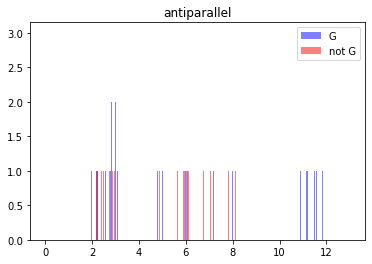

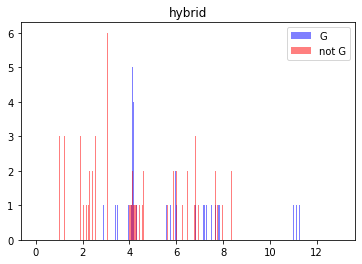

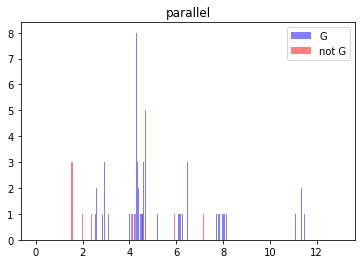

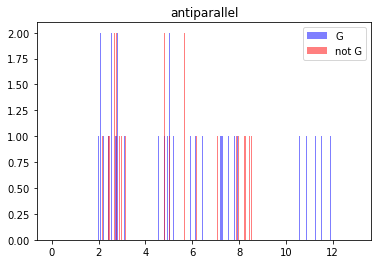

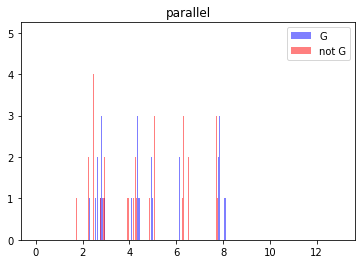

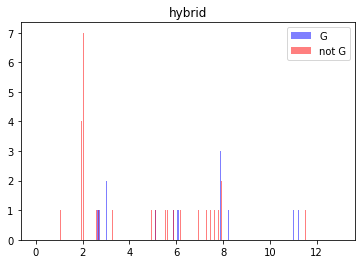

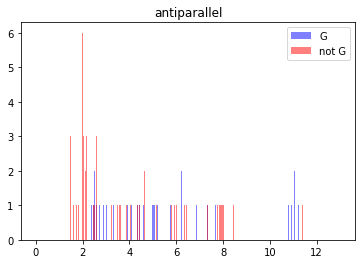

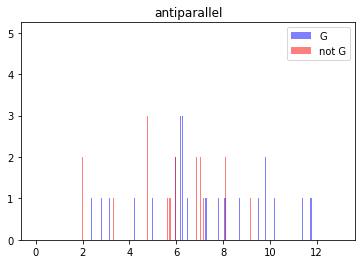

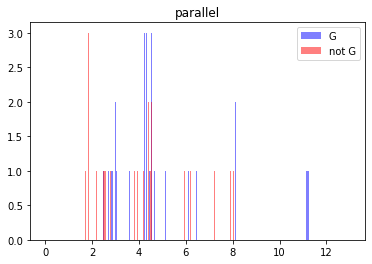

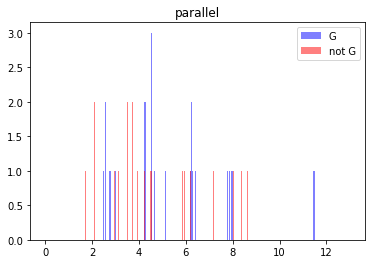

In [ ]:
def full_spectre(name):
    text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+3]!= "1  ":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)


    ind_end = ind_start
    while text[ind_end:ind_end+5]!= "stop_":
        ind_end = following_line(text,ind_end)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')

    peaksG = []
    peaksnotG = []

    quad = build_g4(name)

#     n_atoms = []                 #On sélectionne les déplacements chimiques seulement dans les tétrades
#     t = quad.t
#     for x in t:
#         for y in x:
#             n_atoms.append(y.nb)



    for k in range(len(data)):
        peak = data.iloc[k,9]
        if data.iloc[k,5] =="DG":
            peaksG.append(peak)
        else:
            peaksnotG.append(peak)


    peaksG = np.array(peaksG)
    peaksnotG = np.array(peaksnotG)

    type = quad.topologie
    plt.figure()
    plt.hist(peaksG,bins = 1000, range = (0,13),color = 'blue',alpha = 0.5,label = "G")
    plt.hist(peaksnotG,bins = 1000, range = (0,13),color = 'red',alpha = 0.5,label = "not G")
    plt.title(quad.topologie)
    plt.legend()
    plt.show()

for name in good_g4[20:30]:
    full_spectre(name)

In [ ]:
good_g4[3]

'6KFJ'

## Observons les pics selon Anti ou Syn dans les tétrades

In [ ]:
def get_spectre_G(name):  #On focus que sur les G des tétrades
    text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+44]!= "_Atom_chem_shift.Assigned_chem_shift_list_ID":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)

    ind_start = following_line(text,ind_start)

    ind_end = ind_start
    while text[ind_end:ind_end+5]!= "stop_":
        ind_end = following_line(text,ind_end)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')


    quad = build_g4(name)

    n_atoms = []                 #On sélectionne les déplacements chimiques seulement dans les tétrades
    t = quad.t
    g_list = []
    for x in t:
        for y in x:
            g_list.append(y)
            n_atoms.append(y.nb)

    Hist_syn = []
    Hist_anti = []

    for nb in n_atoms:
        peaks = []
        for k in range(len(data)):
            if data.iloc[k,3] == nb:
                peak = data.iloc[k,9]
                peaks.append(peak)
        G = g_from_nb(g_list,nb)
        conf = G.conformation


        if conf == 1:
            Hist_anti += peaks
        else:
            Hist_syn += peaks
    return Hist_anti, Hist_syn


all_syn = []
all_anti = []


for name in good_g4:
    a,s = get_spectre_G(name)
    all_syn += s
    all_anti += a


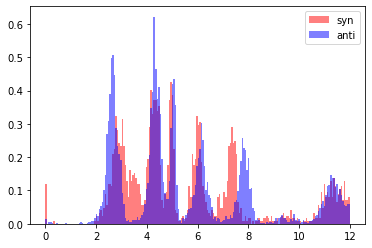

In [ ]:
plt.figure()
plt.hist(all_syn,bins = 200, range = (0,12),density = True,color = "red",alpha = 0.5, label = 'syn')
plt.hist(all_anti,bins = 200, range = (0,12),density = True,color = "blue",alpha = 0.5,label = 'anti')
plt.legend()
plt.show()

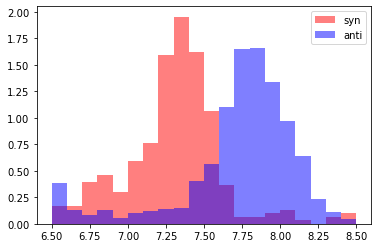

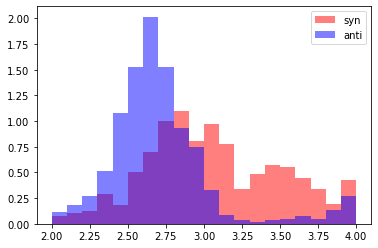

In [ ]:
# zoom sur les plages intéressantes

plt.figure()
plt.hist(all_syn,bins = 20, range = (6.5,8.5),density = True,color = "red",alpha = 0.5, label = 'syn')
plt.hist(all_anti,bins = 20, range = (6.5,8.5),density = True,color = "blue",alpha = 0.5,label = 'anti')
plt.legend()
plt.show()

plt.figure()
plt.hist(all_syn,bins = 20, range = (2,4),density = True,color = "red",alpha = 0.5, label = 'syn')
plt.hist(all_anti,bins = 20, range = (2,4),density = True,color = "blue",alpha = 0.5,label = 'anti')
plt.legend()
plt.show()




## Estimation paramètre distrib normale pour les 2 plages

In [ ]:
def get_spectre_plage7(name):  #On focus que sur les G des tétrades
    text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+44]!= "_Atom_chem_shift.Assigned_chem_shift_list_ID":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)

    ind_start = following_line(text,ind_start)

    ind_end = ind_start
    while text[ind_end:ind_end+5]!= "stop_":
        ind_end = following_line(text,ind_end)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')


    quad = build_g4(name)

    n_atoms = []                 #On sélectionne les déplacements chimiques seulement dans les tétrades
    t = quad.t
    g_list = []
    for x in t:
        for y in x:
            g_list.append(y)
            n_atoms.append(y.nb)

    Hist_syn = []
    Hist_anti = []

    for nb in n_atoms:
        peaks = []
        for k in range(len(data)):
            if data.iloc[k,3] == nb:
                peak = data.iloc[k,9]
                if 6.9 < peak and peak < 8.5:
                    peaks.append(peak)
        G = g_from_nb(g_list,nb)
        conf = G.conformation


        if conf == 1:
            Hist_anti += peaks
        else:
            Hist_syn += peaks
    return Hist_anti, Hist_syn


all_syn = []
all_anti = []


for name in good_g4:
    a,s = get_spectre_plage7(name)
    all_syn += s
    all_anti += a

7.383849056603773 0.2524280727911859
7.808649415204679 0.2512748520089001


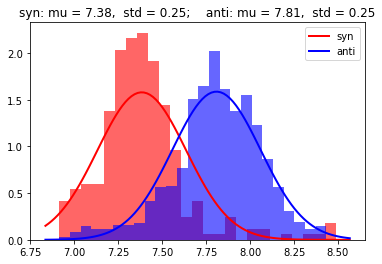

In [ ]:
from scipy.stats import norm

mu_syn, std_syn = norm.fit(all_syn)
mu_anti, std_anti = norm.fit(all_anti)

print(mu_syn,std_syn)
print(mu_anti,std_anti)

# Plot the histogram.
plt.hist(all_syn, bins=25, density=True, alpha=0.6, color='r')
plt.hist(all_anti, bins=25, density=True, alpha=0.6, color='b')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
ps = norm.pdf(x, mu_syn, std_syn)
pa = norm.pdf(x, mu_anti, std_anti)
plt.plot(x, ps, 'k',color = "red", linewidth=2, label = "syn")
plt.plot(x, pa, 'k', color = "blue", linewidth=2, label = "anti")
title = "syn: mu = %.2f,  std = %.2f" % (mu_syn, std_syn) + ";    anti: mu = %.2f,  std = %.2f" % (mu_anti, std_anti)
plt.title(title)
plt.legend()

plt.show()

# # Plot the histogram.
# plt.hist(all_anti, bins=25, density=True, alpha=0.6, color='g')

# # Plot the PDF.
# xmin, xmax = plt.xlim()
# x = np.linspace(xmin, xmax, 100)
# pa = norm.pdf(x, mu_anti, std_anti)
# plt.plot(x, pa, 'k', linewidth=2)
# title = "Fit results: mu = %.2f,  std = %.2f" % (mu_anti, std_anti)
# plt.title(title)

# plt.show()

In [ ]:
def get_spectre_plage2(name):  #On focus que sur les G des tétrades
    text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+44]!= "_Atom_chem_shift.Assigned_chem_shift_list_ID":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)

    ind_start = following_line(text,ind_start)

    ind_end = ind_start
    while text[ind_end:ind_end+5]!= "stop_":
        ind_end = following_line(text,ind_end)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')


    quad = build_g4(name)

    n_atoms = []                 #On sélectionne les déplacements chimiques seulement dans les tétrades
    t = quad.t
    g_list = []
    for x in t:
        for y in x:
            g_list.append(y)
            n_atoms.append(y.nb)

    Hist_syn = []
    Hist_anti = []

    for nb in n_atoms:
        peaks = []
        for k in range(len(data)):
            if data.iloc[k,3] == nb:
                peak = data.iloc[k,9]
                if 2 < peak and peak < 4:
                    peaks.append(peak)
        G = g_from_nb(g_list,nb)
        conf = G.conformation


        if conf == 1:
            Hist_anti += peaks
        else:
            Hist_syn += peaks
    return Hist_anti, Hist_syn


all_syn2 = []
all_anti2 = []


for name in good_g4:
    a,s = get_spectre_plage2(name)
    all_syn2 += s
    all_anti2 += a

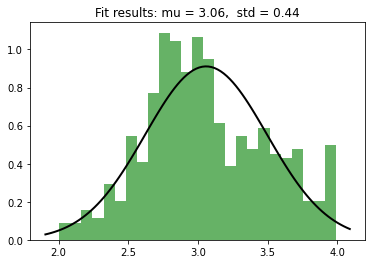

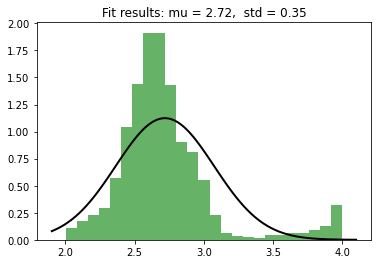

In [ ]:
mu_syn2, std_syn2 = norm.fit(all_syn2)
mu_anti2, std_anti2 = norm.fit(all_anti2)


# Plot the histogram.
plt.hist(all_syn2, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_syn2, std_syn2)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu_syn2, std_syn2)
plt.title(title)

plt.show()

# Plot the histogram.
plt.hist(all_anti2, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu_anti2, std_anti2)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu_anti2, std_anti2)
plt.title(title)

plt.show()

## On va calculer une sorte d'espérance de syn et anti en faisant un focus sur les plages 7-8.5 et 2-4

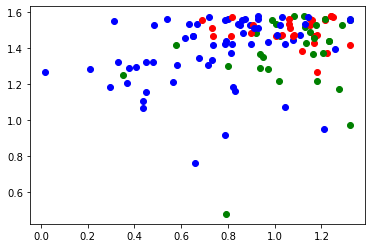

In [ ]:
def gaussian(mu,std,x):
    return 1/np.sqrt(2*np.pi*std**2)*np.exp(-(x-mu)**2/(2*std**2))

data = np.loadtxt('data_brut.txt')

def esp_syn_anti(peaks,mu_s,std_s,mu_a,std_a,inf,sup):
    pas = 12/len(peaks)
    esp_syn = 0
    esp_anti = 0
    for k in range(int(inf/pas),int(sup//pas+1)):
        if peaks[k] != 0:
            if gaussian(mu_s,std_s,k*pas) < gaussian(mu_a,std_a,k*pas):
                esp_anti += gaussian(mu_a,std_a,k*pas)*pas
            else:
                esp_syn += gaussian(mu_s,std_s,k*pas)*pas
    return esp_syn,esp_anti

plt.figure()
for k in range(len(data)):
    peaks = data[k][:-1]
    label = data[k][-1]
    esp_syn = 0
    esp_anti = 0
    s,a = esp_syn_anti(peaks,mu_syn,std_syn,mu_anti,std_anti,7,8.5)
    esp_syn += s
    esp_anti += a
    s,a = esp_syn_anti(peaks,mu_syn2,std_syn2,mu_anti2,std_anti2,2,4)
    esp_syn += s
    esp_anti += a
    if label == 0:
        plt.plot([esp_syn],[esp_anti],"b-o",label = 'parallel')
    elif label == 1:
        plt.plot([esp_syn],[esp_anti],"g-o",label='antiparallel')
    elif label == 2:
        plt.plot([esp_syn],[esp_anti],"r-o",label='hybrid')
plt.show()

Trop de bruit dû aux autre nucléotides pour séparer les syn et anti.

## Calcul de features (voir intuition derrière ces features plus bas)

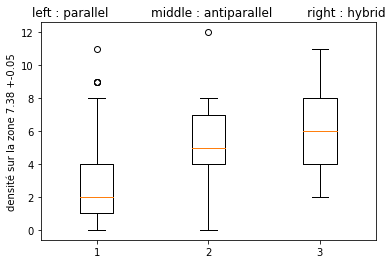

In [ ]:
def density(mu1,mu2,peaks,eps1,eps2):  #On regarde la densité d'une plage où est censé apparaitre des H1 dûs aux G de conformation syn
    pas = 12/len(peaks)
    d1 = 0
    d2=0
    for k in range(int((mu1-eps1)/pas),int((mu1+eps1)//pas+1)):
        d1+=peaks[k]
    for k in range(int((mu2-eps2)/pas),int((mu2+eps2)//pas+1)):
        d2+=peaks[k]
#     if d2!=0:
    return d1
#     else:
#         return 0

data = np.loadtxt('data_brut.txt')

d_p = []
d_a = []
d_h = []

for k in range(len(data)):
    peaks = data[k][:-1]
    label = data[k][-1]
    d = density(mu_syn,mu_anti,peaks,std_syn/5,std_anti/5)
    if label == 0:
        d_p.append(d)
    elif label == 1:
        d_a.append(d)
    elif label == 2:
        d_h.append(d)

plt.figure()
plt.boxplot([d_p,d_a,d_h])
plt.ylabel("densité sur la zone 7.38 +-0.05")
plt.title("left : parallel           middle : antiparallel         right : hybrid"   )
plt.show()

def dense7(X):  #calcul feature vu précédemment
    return density(mu_syn,mu_anti,X,std_syn/5,std_anti/5)

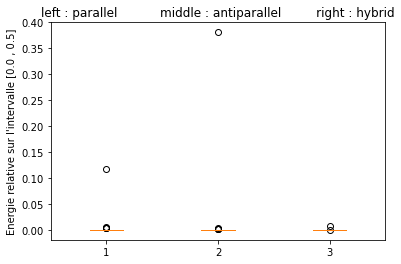

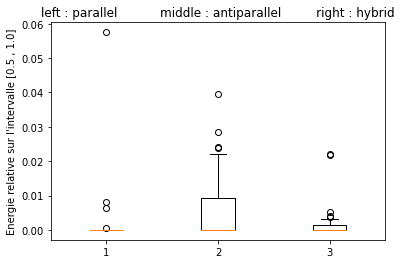

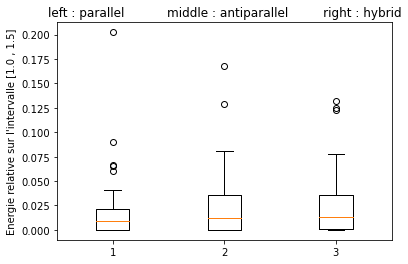

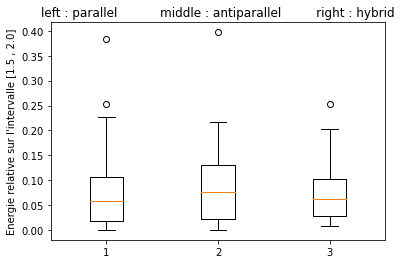

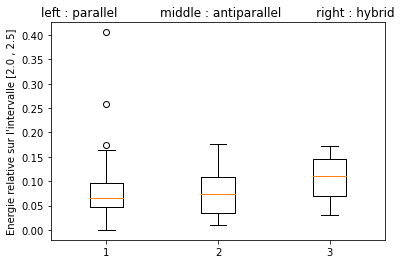

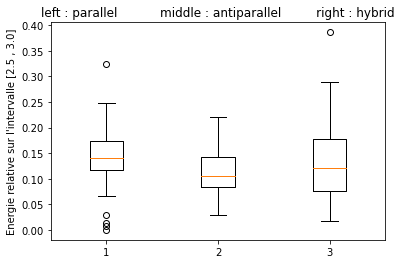

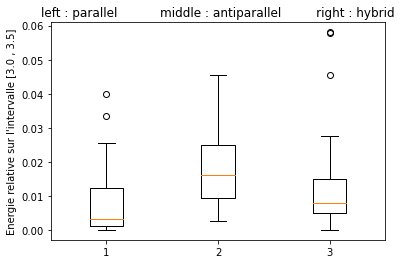

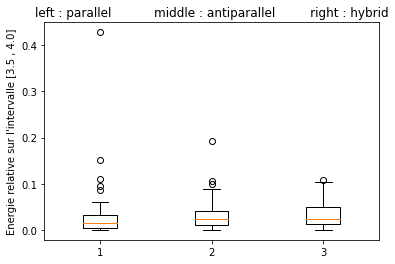

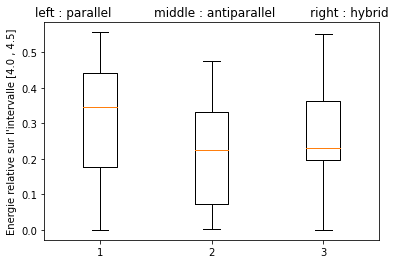

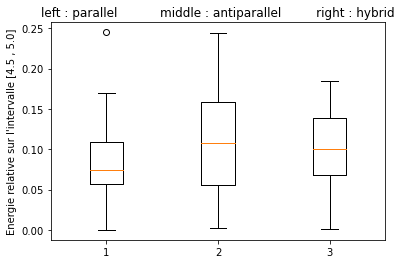

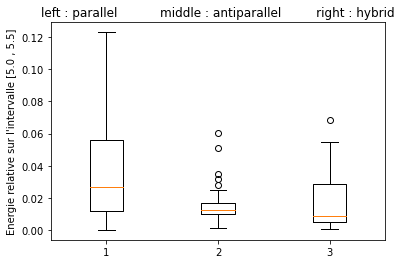

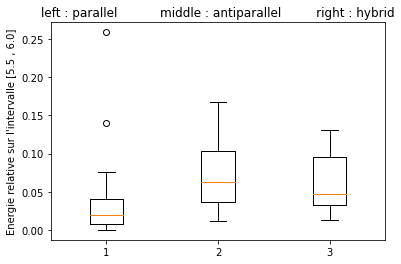

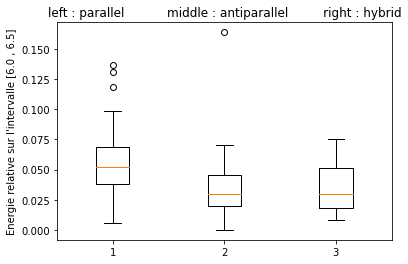

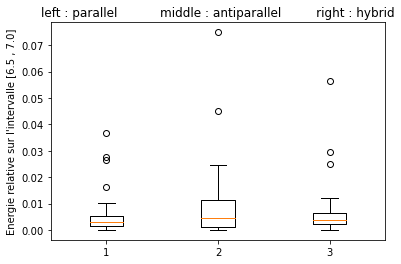

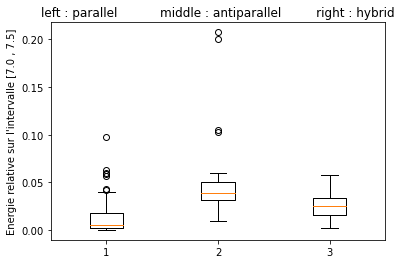

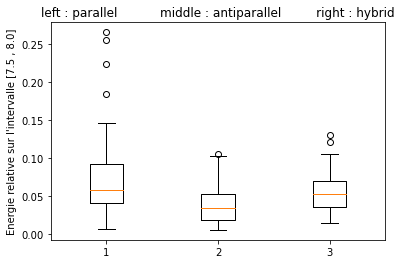

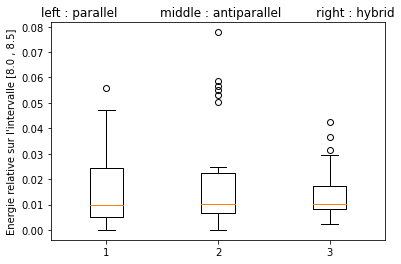

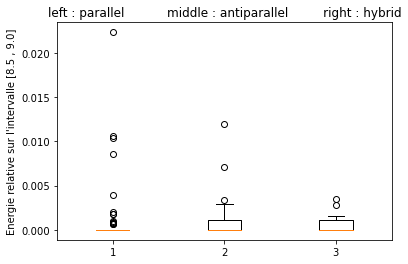

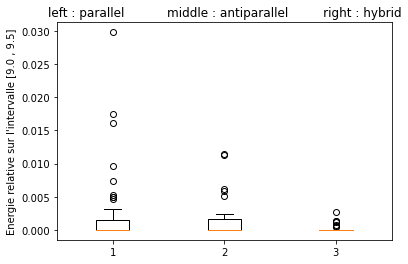

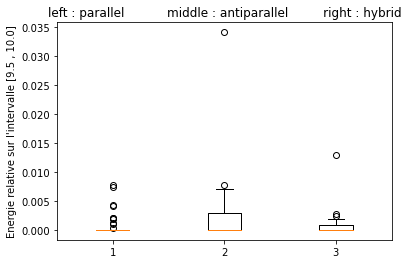

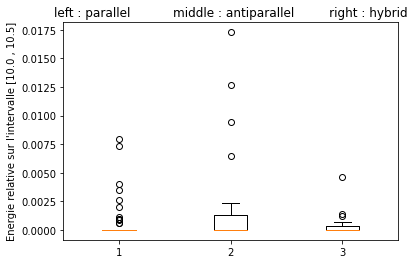

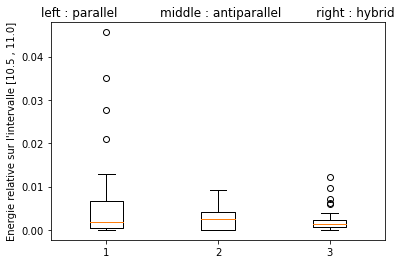

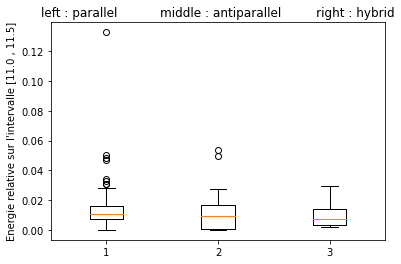

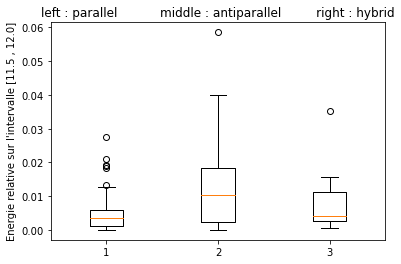

In [ ]:
def mean_energy(X):     #calcule des énergies moyennes sur plusieurs plages du spectre
    tot_energy = np.sum(np.square(X))
    E = np.zeros(24)
    for k in range(len(X)):
        E[int(k*24/len(X))]+= X[k]**2
    E = E/tot_energy
    return E

data = np.loadtxt('data_brut.txt')


e_p = []
e_a = []
e_h = []

for k in range(len(data)):
    peaks = data[k][:-1]
    label = data[k][-1]
    energy = mean_energy(peaks)
    if label == 0:
        e_p.append(energy)
    elif label == 1:
        e_a.append(energy)
    elif label == 2:
        e_h.append(energy)

e_p = np.array(e_p)
e_a = np.array(e_a)
e_h = np.array(e_h)

for i in range(24):
    plt.figure()
    plt.boxplot([e_p[:,i],e_a[:,i],e_h[:,i]])
    plt.title("left : parallel           middle : antiparallel         right : hybrid"   )
    plt.ylabel("Energie relative sur l'intervalle ["+str(i*0.5)+" , "+str(i*0.5+0.5)+"]")
    plt.show()

In [ ]:
data = np.loadtxt('data_brut.txt')

features = np.zeros((len(data),25))

for k in range(len(data)):
    peaks = data[k][:-1]
    label = data[k][-1]
    d = dense7(peaks)
    energy = mean_energy(peaks)
    features[k,:] = np.concatenate(([d],energy))

for k in range(25):
    features[:,k] = features[:,k] - np.mean(features[:,k])
    features[:,k] = features[:,k]/np.std(features[:,k])

data_set_features = np.zeros((len(data),26))
for k in range(len(data)):
    data_set_features[k,:] = np.concatenate((features[k,:],[data[k][-1]]))

np.random.shuffle(data_set_features)

np.savetxt('data_features.txt', data_set_features, fmt='%f')   #dataset pour spectre complet avec tous les dép chimiques


# data = np.loadtxt('data_brut.txt')

# features = np.zeros((len(data),25))

# for k in range(len(data)):
#     peaks = data[k][:-1]
#     label = data[k][-1]
#     d = dense7(peaks)
#     energy = mean_energy(peaks)
#     features[k,:] = np.concatenate(([d],energy))

# for k in range(25):
#     features[:,k] = features[:,k] - np.mean(features[:,k])
#     features[:,k] = features[:,k]/np.std(features[:,k])

# data_set_features = np.zeros((len(data),26))
# for k in range(len(data)):
#     if data[k][-1] == 0:
#         data_set_features[k,:] = np.concatenate((features[k,:],[0]))
#     else:
#         data_set_features[k,:] = np.concatenate((features[k,:],[1]))

# np.random.shuffle(data_set_features)

# np.savetxt('data_features.txt', data_set_features, fmt='%f')   #dataset pour spectre complet avec tous les dép chimiques

# data = np.loadtxt('data_brut.txt')

# features = np.zeros((len(data)-62,25))

# c = 0
# for k in range(len(data)):
#     peaks = data[k][:-1]
#     label = data[k][-1]
#     d = dense7(peaks)
#     energy = mean_energy(peaks)
#     if label != 0:
#         features[c,:] = np.concatenate(([d],energy))
#         c+=1

# for k in range(25):
#     features[:,k] = features[:,k] - np.mean(features[:,k])
#     features[:,k] = features[:,k]/np.std(features[:,k])

# c = 0
# data_set_features = np.zeros((len(data)-62,26))
# for k in range(len(data)):
#     if data[k][-1] == 0:
# #         data_set_features[k,:] = np.concatenate((features[k,:],[0]))
#         print("youpi")
#     else:
#         data_set_features[c,:] = np.concatenate((features[c,:],[data[k][-1]]))
#         c+=1

# np.random.shuffle(data_set_features)



# np.savetxt('data_features.txt', data_set_features, fmt='%f')   #dataset pour spectre complet avec tous les dép chimiques

# print(data_set_features)

In [ ]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier



D = np.loadtxt('data_features.txt')

n_arbres = [5,10,20,30,40,50]
depth = [3,4,5,6,7,8,9,10]

N = 100

max_n = 5
max_acc = 0
max_d = 3

for n in n_arbres:
    for d in depth:
        mean_acc = 0
        for i in range(N):
            np.random.shuffle(D)

            n_train = 85

            X_train = D[:n_train,:-1]
            Y_train = D[:n_train,-1]

            X_test = D[n_train:,:-1]
            Y_test = D[n_train:,-1]

            clff = RandomForestClassifier(10,max_depth = 5, random_state=0,class_weight = "balanced_subsample")
            clff.fit(X_train, Y_train)

            pred = clff.predict(X_test)

            acc = 0
            for k in range(len(pred)):
                if pred[k] == Y_test[k]:
                    acc +=1

            acc = 100*acc/len(pred)
            mean_acc += acc/N
        if mean_acc > max_acc:
            max_acc = mean_acc
            max_n = n
            max_d = d

print(max_acc, max_n, max_d)

63.027777777777786 40 4


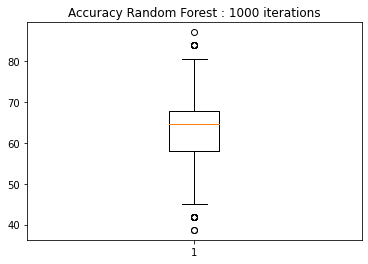

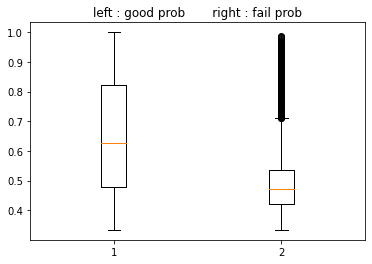

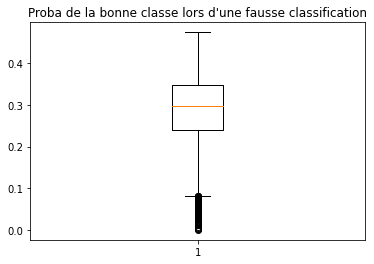

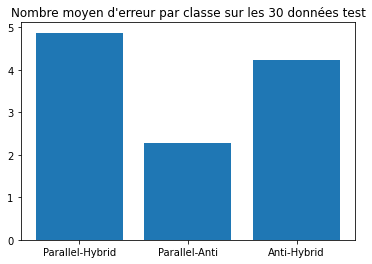

In [ ]:
D = np.loadtxt('data_features.txt')

acc_list = []

ph = 0
pa = 0
ah = 0

good_prob = []
fail_prob = []

prob_when_fail = []

for n in range(1000):


    np.random.shuffle(D)

    n_train = 90

    X_train = D[:n_train,:-1]
    Y_train = D[:n_train,-1]

    X_test = D[n_train:,:-1]
    Y_test = D[n_train:,-1]

    clff = RandomForestClassifier(40,max_depth = 4, random_state=0,class_weight = "balanced")
    clff.fit(X_train, Y_train)

    pred = clff.predict(X_test)
    pred_proba = clff.predict_proba(X_test)

    acc = 0
    for k in range(len(pred)):
        if pred[k] == Y_test[k]:
            acc +=1

    acc = 100*acc/len(pred)

    acc_list.append(acc)

    p_h = 0
    p_a = 0
    h_a = 0


    n_test = len(X_test)

    for k in range(len(pred)):
        r = pred[k]
        label = Y_test[k]
        if r == label:
             good_prob.append(pred_proba[k][int(r)])

        else:
            prob_when_fail.append(pred_proba[k][int(label)])
            fail_prob.append(pred_proba[k][int(r)])
            if r == 0:
                if label == 1:
                    p_a +=1
                elif label == 2:
                    p_h +=1
            elif r == 1:
                if label == 0:
                    p_a +=1
                elif label == 2:
                    h_a +=1
            elif r == 2:
                if label == 0:
                    p_h +=1
                elif label == 1:
                    h_a +=1

    pa += p_a/1000
    ph += p_h /1000
    ah += h_a/1000

plt.figure()
plt.boxplot(acc_list)
plt.title("Accuracy Random Forest : 1000 iterations")
plt.show()

plt.figure()
plt.boxplot([good_prob,fail_prob])
plt.title("left : good prob       right : fail prob")
plt.show()

plt.figure()
plt.boxplot(prob_when_fail)
plt.title("Proba de la bonne classe lors d'une fausse classification")
plt.show()

labels = ["Parallel-Hybrid","Parallel-Anti","Anti-Hybrid"]

plt.figure()
plt.bar(labels,[ph,pa,ah])
plt.title("Nombre moyen d'erreur par classe sur les 30 données test")
plt.show()

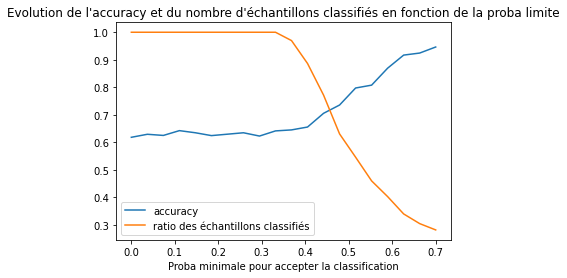

In [ ]:
D = np.loadtxt('data_features.txt')

prob_limit_list = np.linspace(0,0.7,20)

ratio_classifies = []
accuracy = []

for prob_limit in prob_limit_list:

    acc_list = []

    ph = 0
    pa = 0
    ah = 0

    ratio_class = []

    for n in range(100):


        np.random.shuffle(D)

        n_train = 90

        X_train = D[:n_train,:-1]
        Y_train = D[:n_train,-1]

        X_test = D[n_train:,:-1]
        Y_test = D[n_train:,-1]

        clff = RandomForestClassifier(40,max_depth = 4, random_state=0,class_weight = "balanced")
        clff.fit(X_train, Y_train)

        pred = clff.predict(X_test)
        pred_proba = clff.predict_proba(X_test)

        n_sample_class = 0
        n_sample_not_class = 0

        acc = 0
        for k in range(len(pred)):
            r = pred[k]
            if pred_proba[k][int(r)]> prob_limit:
                n_sample_class +=1
                if pred[k] == Y_test[k]:
                    acc +=1
            else:
                n_sample_not_class +=1

        acc = acc/n_sample_class

        acc_list.append(acc)

        ratio_class.append(n_sample_class/len(pred))

        p_h = 0
        p_a = 0
        h_a = 0

    ratio_classifies.append(np.mean(ratio_class))
    accuracy.append(np.mean(acc_list))


plt.figure()
plt.plot(prob_limit_list,accuracy,label = 'accuracy')
plt.plot(prob_limit_list,ratio_classifies,label = 'ratio des échantillons classifiés')
plt.xlabel("Proba minimale pour accepter la classification")
plt.legend()
plt.title("Evolution de l'accuracy et du nombre d'échantillons classifiés en fonction de la proba limite")
plt.show()




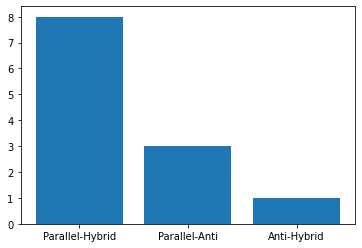

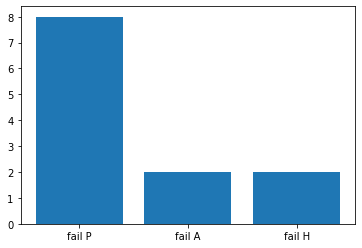

In [ ]:
p_h = 0
p_a = 0
h_a = 0

p_f = 0
a_f = 0
h_f = 0

pred = clff.predict(D[:,:-1])

for k in range(len(D)):
    r = pred[k]
    if r == 0:
        label = D[k,-1]
        if label == 1:
            p_a +=1
        elif label == 2:
            p_h +=1
    elif r == 1:
        label = D[k,-1]
        if label == 0:
            p_a +=1
        elif label == 2:
            h_a +=1
    elif r == 2:
        label = D[k,-1]
        if label == 0:
            p_h +=1
        elif label == 1:
            h_a +=1

for k in range(len(D)):
    label = label = D[k,-1]
    r = pred[k]
    if r != label:
        if label == 0:
            p_f+=1
        elif label ==1 :
            a_f+=1
        else:
            h_f +=1


labels = ["Parallel-Hybrid","Parallel-Anti","Anti-Hybrid"]
labels_bis = ["fail P",'fail A','fail H']

plt.figure()
plt.bar(labels,[p_h,p_a,h_a])
plt.show()

plt.figure()
plt.bar(labels_bis,[p_f,a_f,h_f])
plt.show()

## SVM

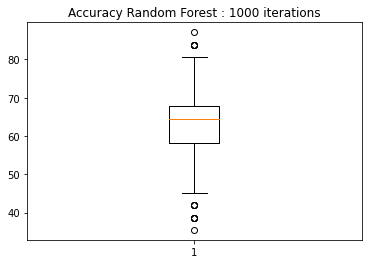

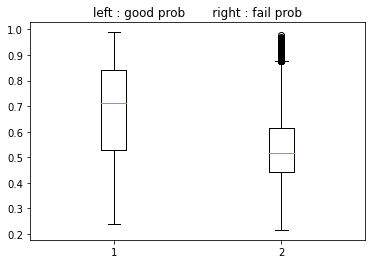

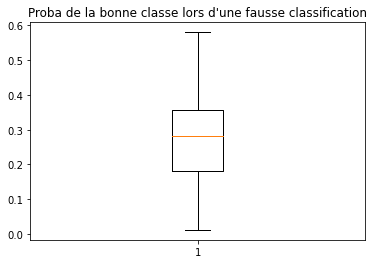

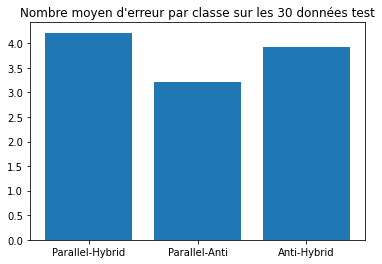

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler



D = np.loadtxt('data_features.txt')

acc_list = []

ph = 0
pa = 0
ah = 0

good_prob = []
fail_prob = []

prob_when_fail = []

for n in range(1000):


    np.random.shuffle(D)

    n_train = 90

    X_train = D[:n_train,:-1]
    Y_train = D[:n_train,-1]

    X_test = D[n_train:,:-1]
    Y_test = D[n_train:,-1]

    clf = make_pipeline(StandardScaler(), SVC(C = 2,gamma='auto',probability = True))
    clf.fit(X_train, Y_train)

    pred = clf.predict(X_test)
    pred_proba = clf.predict_proba(X_test)

    acc = 0
    for k in range(len(pred)):
        if pred[k] == Y_test[k]:
            acc +=1

    acc = 100*acc/len(pred)

    acc_list.append(acc)

    p_h = 0
    p_a = 0
    h_a = 0


    n_test = len(X_test)

    for k in range(len(pred)):
        r = pred[k]
        label = Y_test[k]
        if r == label:
             good_prob.append(pred_proba[k][int(r)])

        else:
            prob_when_fail.append(pred_proba[k][int(label)])
            fail_prob.append(pred_proba[k][int(r)])
            if r == 0:
                if label == 1:
                    p_a +=1
                elif label == 2:
                    p_h +=1
            elif r == 1:
                if label == 0:
                    p_a +=1
                elif label == 2:
                    h_a +=1
            elif r == 2:
                if label == 0:
                    p_h +=1
                elif label == 1:
                    h_a +=1

    pa += p_a/1000
    ph += p_h /1000
    ah += h_a/1000

plt.figure()
plt.boxplot(acc_list)
plt.title("Accuracy Random Forest : 1000 iterations")
plt.show()

plt.figure()
plt.boxplot([good_prob,fail_prob])
plt.title("left : good prob       right : fail prob")
plt.show()

plt.figure()
plt.boxplot(prob_when_fail)
plt.title("Proba de la bonne classe lors d'une fausse classification")
plt.show()

labels = ["Parallel-Hybrid","Parallel-Anti","Anti-Hybrid"]

plt.figure()
plt.bar(labels,[ph,pa,ah])
plt.title("Nombre moyen d'erreur par classe sur les 30 données test")
plt.show()

## Features espacement

In [ ]:
def get_chem_shift(name):
    text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+3]!= "1  ":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)


    ind_end = ind_start
    while text[ind_end:ind_end+5]!= "stop_":
        ind_end = following_line(text,ind_end)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')

    peaks = []



    for k in range(len(data)):
        peak = data.iloc[k,9]
        if type(peak) != str and 0<peak and peak<12:
            peaks.append(peak)

    peaks = np.array(peaks)
    return peaks

data_chem_shift = []

def find_g4(l,name):
    for g in l:
        if g.name == name:
            return g
    return "no found"

X = []
c = 0
for name in good_g4:
    c+=1
    print(c)
    g = find_g4(g4_list,name)
    peaks = get_chem_shift(name)
    topo = g.g4.topologie
    if topo=="parallel":
        t = 0
    elif topo=="antiparallel":
        t = 1
    else:
        t = 2
    data_chem_shift.append(np.concatenate((peaks,np.array([t]))))
    try:
        hist = get_spectre_all(name)
        X.append(hist)
    except IndexError:
        print(name)

data_brut = []

for k in range(len(X)):                   #On divise par la masse de chaque échantillon pour avoir une distribution d'histogrammes
    if np.sum(X[k])!=0:     # On trie d'éventuels échantillons vides
        data_brut.append(np.concatenate((X[k],[label_g4[k]])))
    else:
        print(k)

data_brut = np.array(data_brut)




1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121


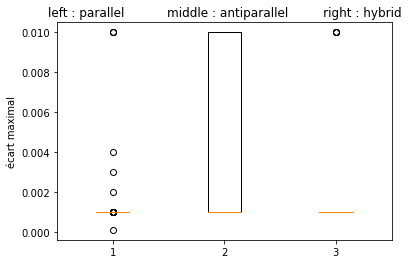

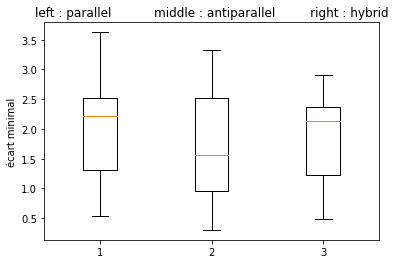

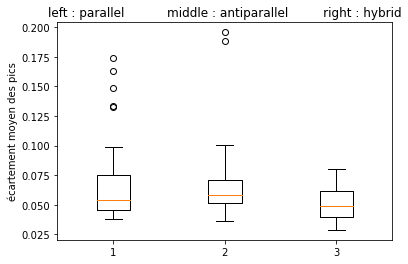

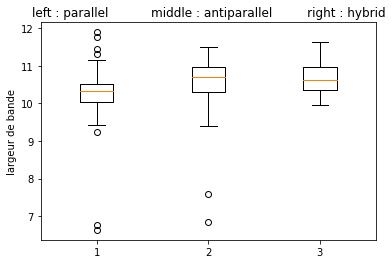

In [ ]:
def espacement(X):
    peaks = np.copy(X)
    peaks = np.sort(peaks)
    maxi = 0
    mini = np.inf
    dist = 0
    for k in range(len(peaks)-1):
        d =peaks[k+1]-peaks[k]
        dist += d
        if d<mini and d!=0:
            mini = d
        if d>maxi:
            maxi = d
    if len(peaks) != 0:
        return mini,maxi, dist/len(peaks),peaks[-1]-peaks[0]
    else:
        return 0,0,0,0


esp_p = []
esp_a = []
esp_h = []

for k in range(len(data)):
    peaks = data_chem_shift[k][:-1]
    label = data_chem_shift[k][-1]
    mini,maxi,esp,ampl = espacement(peaks)
    if label == 0:
        esp_p.append([mini,maxi,esp,ampl])
    elif label == 1:
        esp_a.append([mini,maxi,esp,ampl])
    elif label == 2:
        esp_h.append([mini,maxi,esp,ampl])

esp_p = np.array(esp_p)
esp_a = np.array(esp_a)
esp_h = np.array(esp_h)


plt.figure()
plt.boxplot([esp_p[:,0],esp_a[:,0],esp_h[:,0]])
plt.ylabel("écart maximal")
plt.title("left : parallel           middle : antiparallel         right : hybrid"   )
plt.show()

plt.figure()
plt.boxplot([esp_p[:,1],esp_a[:,1],esp_h[:,1]])
plt.ylabel("écart minimal")
plt.title("left : parallel           middle : antiparallel         right : hybrid"   )
plt.show()

plt.figure()
plt.boxplot([esp_p[:,2],esp_a[:,2],esp_h[:,2]])
plt.ylabel("écartement moyen des pics")
plt.title("left : parallel           middle : antiparallel         right : hybrid"   )
plt.show()

plt.figure()
plt.boxplot([esp_p[:,3],esp_a[:,3],esp_h[:,3]])
plt.ylabel("largeur de bande")
plt.title("left : parallel           middle : antiparallel         right : hybrid"   )
plt.show()

In [ ]:
features = np.zeros((len(data),29))

for k in range(len(data_brut)):
    peaks = data_brut[k][:-1]
    label = data_brut[k][-1]
    shift = data_chem_shift[k][:-1]
    d = dense7(peaks)
    energy = mean_energy(peaks)
    mini,maxi,esp,ampl = espacement(shift)
    features[k,:] = np.concatenate(([d],energy,np.array([mini,maxi,esp,ampl])))

for k in range(29):
    features[:,k] = features[:,k] - np.mean(features[:,k])
    features[:,k] = features[:,k]/np.std(features[:,k])

data_set_features = np.zeros((len(data),30))
for k in range(len(data)):
    data_set_features[k,:] = np.concatenate((features[k,:],[data[k][-1]]))

np.random.shuffle(data_set_features)

np.savetxt('data_features_all.txt', data_set_features, fmt='%f')   #dataset pour spectre complet avec tous les dép chimiques

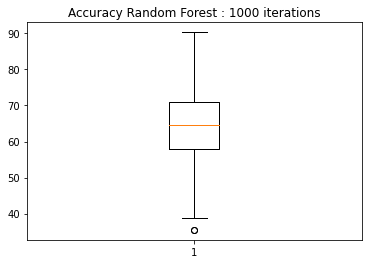

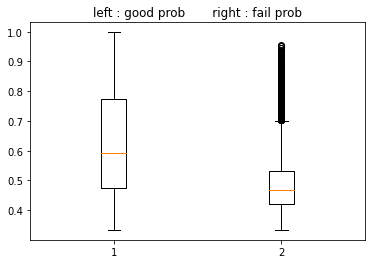

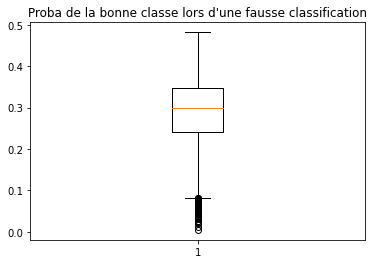

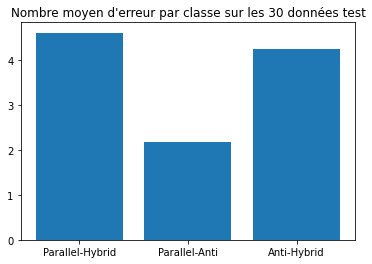

In [ ]:
D = np.loadtxt('data_features_all.txt')

acc_list = []

ph = 0
pa = 0
ah = 0

good_prob = []
fail_prob = []

prob_when_fail = []

for n in range(1000):


    np.random.shuffle(D)

    n_train = 90

    X_train = D[:n_train,:-1]
    Y_train = D[:n_train,-1]

    X_test = D[n_train:,:-1]
    Y_test = D[n_train:,-1]

    clff = RandomForestClassifier(40,max_depth = 4, random_state=0,class_weight = "balanced")
    clff.fit(X_train, Y_train)

    pred = clff.predict(X_test)
    pred_proba = clff.predict_proba(X_test)

    acc = 0
    for k in range(len(pred)):
        if pred[k] == Y_test[k]:
            acc +=1

    acc = 100*acc/len(pred)

    acc_list.append(acc)

    p_h = 0
    p_a = 0
    h_a = 0


    n_test = len(X_test)

    for k in range(len(pred)):
        r = pred[k]
        label = Y_test[k]
        if r == label:
             good_prob.append(pred_proba[k][int(r)])

        else:
            prob_when_fail.append(pred_proba[k][int(label)])
            fail_prob.append(pred_proba[k][int(r)])
            if r == 0:
                if label == 1:
                    p_a +=1
                elif label == 2:
                    p_h +=1
            elif r == 1:
                if label == 0:
                    p_a +=1
                elif label == 2:
                    h_a +=1
            elif r == 2:
                if label == 0:
                    p_h +=1
                elif label == 1:
                    h_a +=1

    pa += p_a/1000
    ph += p_h /1000
    ah += h_a/1000

plt.figure()
plt.boxplot(acc_list)
plt.title("Accuracy Random Forest : 1000 iterations")
plt.show()

plt.figure()
plt.boxplot([good_prob,fail_prob])
plt.title("left : good prob       right : fail prob")
plt.show()

plt.figure()
plt.boxplot(prob_when_fail)
plt.title("Proba de la bonne classe lors d'une fausse classification")
plt.show()

labels = ["Parallel-Hybrid","Parallel-Anti","Anti-Hybrid"]

plt.figure()
plt.bar(labels,[ph,pa,ah])
plt.title("Nombre moyen d'erreur par classe sur les 30 données test")
plt.show()

## Observation de tous les pics syn, anti et non G pour voir si il y a des zones discriminantes

In [ ]:
def get_spectre_allG(name):  #On focus que sur les G des tétrades
    text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+44]!= "_Atom_chem_shift.Assigned_chem_shift_list_ID":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)

    ind_start = following_line(text,ind_start)

    ind_end = ind_start
    while text[ind_end:ind_end+5]!= "stop_":
        ind_end = following_line(text,ind_end)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')


    quad = build_g4(name)

    n_atoms = []                 #On sélectionne les déplacements chimiques seulement dans les tétrades
    t = quad.t
    g_list = []
    for x in t:
        for y in x:
            g_list.append(y)
            n_atoms.append(y.nb)

    pHist_syn = []
    pHist_anti = []
    pHist_not_G = []

    aHist_syn = []
    aHist_anti = []
    aHist_not_G = []

    hHist_syn = []
    hHist_anti = []
    hHist_not_G = []

    topo = quad.topologie

    if topo == 'parallel':
        for nb in n_atoms:
            peaks = []
            for k in range(len(data)):
                if data.iloc[k,3] == nb:
                    peak = data.iloc[k,9]
                    if 0<peak<12:
                        peaks.append(peak)
            G = g_from_nb(g_list,nb)
            conf = G.conformation

            if conf == 1:
                pHist_anti += peaks
            else:
                pHist_syn += peaks

        for k in range(len(data)):
            if not data.iloc[k,3] in n_atoms:
                peak = data.iloc[k,9]
                if 0<peak<12:
                    pHist_not_G += [peak]

    elif topo == 'antiparallel':
        for nb in n_atoms:
            peaks = []
            for k in range(len(data)):
                if data.iloc[k,3] == nb:
                    peak = data.iloc[k,9]
                    if 0<peak<12:
                        peaks.append(peak)
            G = g_from_nb(g_list,nb)
            conf = G.conformation

            if conf == 1:
                aHist_anti += peaks
            else:
                aHist_syn += peaks


        for k in range(len(data)):
            if not data.iloc[k,3] in n_atoms:
                peak = data.iloc[k,9]
                if 0<peak<12:
                        aHist_not_G += [peak]


    else:
        for nb in n_atoms:
            peaks = []
            for k in range(len(data)):
                if data.iloc[k,5] == "DG":
                    peak = data.iloc[k,9]
                    if 0<peak<12:
                        peaks.append(peak)
            G = g_from_nb(g_list,nb)
            conf = G.conformation

            if conf == 1:
                hHist_anti += peaks
            else:
                hHist_syn += peaks

        for k in range(len(data)):
            if not data.iloc[k,3] in n_atoms:
                peak = data.iloc[k,9]
                if 0<peak<12:
                    hHist_not_G += [peak]
    return pHist_anti, pHist_syn, pHist_not_G, aHist_anti, aHist_syn, aHist_not_G, hHist_anti, hHist_syn, hHist_not_G


pall_syn = []
pall_anti = []
pall_not_G = []
aall_syn = []
aall_anti = []
aall_not_G = []
hall_syn = []
hall_anti = []
hall_not_G = []

for name in good_g4:
    pa,ps,png, aa,a_s,ang, ha,hs,hng = get_spectre_allG(name)
    pall_syn += ps
    pall_anti += pa
    pall_not_G += png
    aall_syn += a_s
    aall_anti += aa
    aall_not_G += ang
    hall_syn += hs
    hall_anti += ha
    hall_not_G += hng

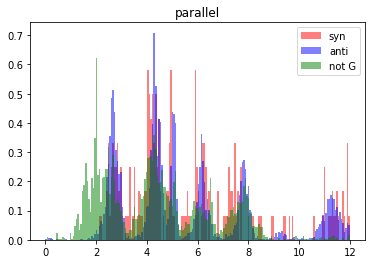

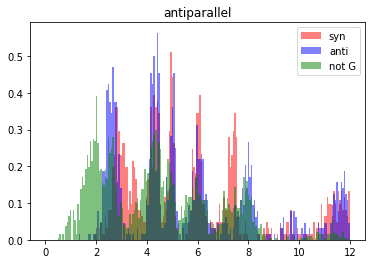

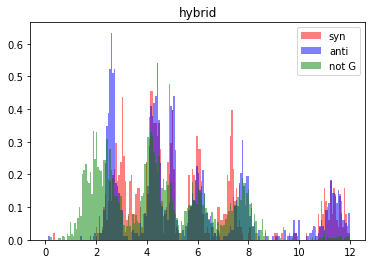

In [ ]:
plt.figure()
plt.hist(pall_syn,bins = 200, range = (0,12),density = True,color = "red",alpha = 0.5, label = 'syn')
plt.hist(pall_anti,bins = 200, range = (0,12),density = True,color = "blue",alpha = 0.5,label = 'anti')
plt.hist(pall_not_G,bins = 200, range = (0,12),density = True,color = "green",alpha = 0.5,label = 'not G')
plt.title("parallel")
plt.legend()
plt.show()

plt.figure()
plt.hist(aall_syn,bins = 200, range = (0,12),density = True,color = "red",alpha = 0.5, label = 'syn')
plt.hist(aall_anti,bins = 200, range = (0,12),density = True,color = "blue",alpha = 0.5,label = 'anti')
plt.hist(aall_not_G,bins = 200, range = (0,12),density = True,color = "green",alpha = 0.5,label = 'not G')
plt.title("antiparallel")
plt.legend()
plt.show()

plt.figure()
plt.hist(hall_syn,bins = 200, range = (0,12),density = True,color = "red",alpha = 0.5, label = 'syn')
plt.hist(hall_anti,bins = 200, range = (0,12),density = True,color = "blue",alpha = 0.5,label = 'anti')
plt.hist(hall_not_G,bins = 200, range = (0,12),density = True,color = "green",alpha = 0.5,label = 'not G')
plt.title("hybrid")
plt.legend()
plt.show()

- On voit que très peu de pics proches de 10ppm pour les parallèles. Donc une première feature peut être la distance min entre les pics et 10 ppm.
- Ensuite, on voit que pour les antiparallele, on peut avoir des pics pour des ppm très proches de 0.
- Enfin, on s'aperçoit que le seul moyen de distinguer des anti et des syn est de regarder entre 7 et 8 ppm car c'est les seuls à avoir 2 gaussiennes séparées.
- Aussi, on voit que très peu de pic vers 7ppm pour parallele.
- Nombre de pics en dessous de 0.5 plus grands pour hybride.

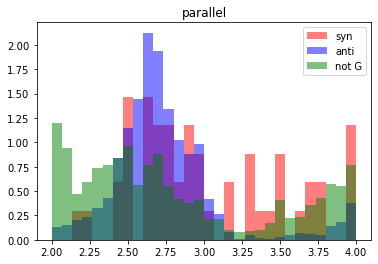

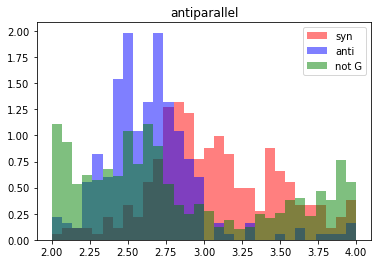

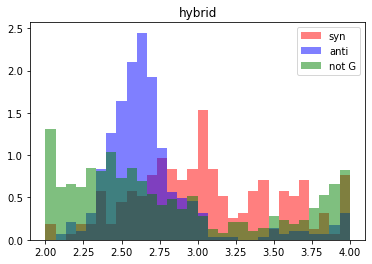

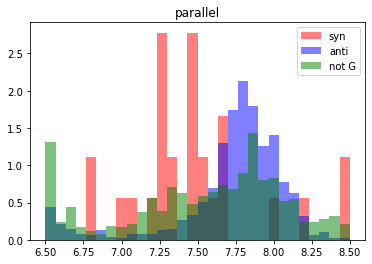

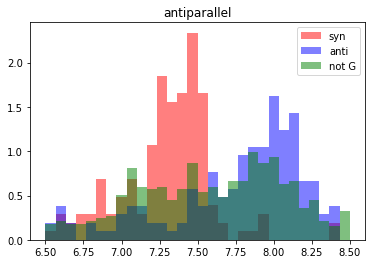

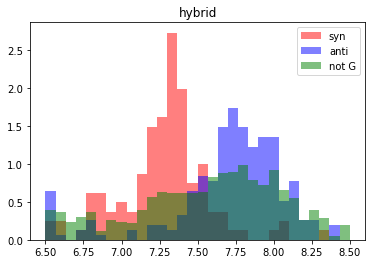

In [ ]:
# zoom sur les plages intéressantes

plt.figure()
plt.hist(pall_syn,bins = 30, range = (2,4),density = True,color = "red",alpha = 0.5, label = 'syn')
plt.hist(pall_anti,bins = 30, range = (2,4),density = True,color = "blue",alpha = 0.5,label = 'anti')
plt.hist(pall_not_G,bins = 30, range = (2,4),density = True,color = "green",alpha = 0.5,label = 'not G')
plt.title("parallel")
plt.legend()
plt.show()

plt.figure()
plt.hist(aall_syn,bins = 30, range = (2,4),density = True,color = "red",alpha = 0.5, label = 'syn')
plt.hist(aall_anti,bins = 30, range = (2,4),density = True,color = "blue",alpha = 0.5,label = 'anti')
plt.hist(aall_not_G,bins = 30, range = (2,4),density = True,color = "green",alpha = 0.5,label = 'not G')
plt.title("antiparallel")
plt.legend()
plt.show()

plt.figure()
plt.hist(hall_syn,bins = 30, range = (2,4),density = True,color = "red",alpha = 0.5, label = 'syn')
plt.hist(hall_anti,bins = 30, range = (2,4),density = True,color = "blue",alpha = 0.5,label = 'anti')
plt.hist(hall_not_G,bins = 30, range = (2,4),density = True,color = "green",alpha = 0.5,label = 'not G')
plt.title("hybrid")
plt.legend()
plt.show()


plt.figure()
plt.hist(pall_syn,bins = 30, range = (6.5,8.5),density = True,color = "red",alpha = 0.5, label = 'syn')
plt.hist(pall_anti,bins = 30, range = (6.5,8.5),density = True,color = "blue",alpha = 0.5,label = 'anti')
plt.hist(pall_not_G,bins = 30, range = (6.5,8.5),density = True,color = "green",alpha = 0.5,label = 'not G')
plt.title("parallel")
plt.legend()
plt.show()

plt.figure()
plt.hist(aall_syn,bins = 30, range = (6.5,8.5),density = True,color = "red",alpha = 0.5, label = 'syn')
plt.hist(aall_anti,bins = 30, range = (6.5,8.5),density = True,color = "blue",alpha = 0.5,label = 'anti')
plt.hist(aall_not_G,bins = 30, range = (6.5,8.5),density = True,color = "green",alpha = 0.5,label = 'not G')
plt.title("antiparallel")
plt.legend()
plt.show()

plt.figure()
plt.hist(hall_syn,bins = 30, range = (6.5,8.5),density = True,color = "red",alpha = 0.5, label = 'syn')
plt.hist(hall_anti,bins = 30, range = (6.5,8.5),density = True,color = "blue",alpha = 0.5,label = 'anti')
plt.hist(hall_not_G,bins = 30, range = (6.5,8.5),density = True,color = "green",alpha = 0.5,label = 'not G')
plt.title("hybrid")
plt.legend()
plt.show()

## Quantification du bruit

5720


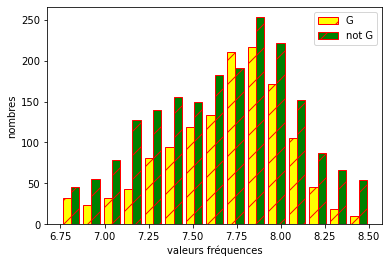

In [ ]:
g = pall_syn + pall_anti + aall_syn + aall_anti + hall_anti + hall_syn

notg = pall_not_G + aall_not_G + hall_not_G

print(len(pall_not_G))

plt.figure()

plt.hist([g, notg], bins = 15, range = (6.75,8.5), color = ['yellow', 'green'],
            edgecolor = 'red', hatch = '/', label = ['G', 'not G'],
            histtype = 'bar')
plt.xlabel('valeurs fréquences')
plt.ylabel('nombres')
plt.legend()
plt.show()

# Jusqu'ici rien ne marche à cause de la contribution des bases A,C,T qui jouent le rôle de bruit, essayons un modèle statistique prenant en compte ces contributions

## Observons l'apport de chaque base ACGT dans le spectre RMN

In [ ]:
def nb_base(name):
    text = urllib.request.urlopen("https://www.rcsb.org/fasta/entry/"+name+"/display").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
     #on tronque le début du fichier qui ne nous est pas utile pour l'instant
    ind_start = following_line(text,ind_start)
    ind_end = following_line(text,ind_start)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" ", header = None,engine = 'python')
    seq = data.iloc[0,0]
    nA=0
    nC=0
    nG=0
    nT=0
    for k in range(len(seq)):
        if seq[k] == "A":
            nA+=1
        elif seq[k] == "C":
            nC+=1
        elif seq[k] == "G":
            nG+=1
        elif seq[k] == "T":
            nT+=1
    return nA,nC,nG,nT

def get_spectre_base(name):  #On focus que sur les G des tétrades
    text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+44]!= "_Atom_chem_shift.Assigned_chem_shift_list_ID":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)

    ind_start = following_line(text,ind_start)

    ind_end = ind_start
    while text[ind_end:ind_end+5]!= "stop_":
        ind_end = following_line(text,ind_end)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')


    histA = []
    histT = []
    histC = []
    histG = []

    for k in range(len(data)):
            peak = data.iloc[k,9]
            base = data.iloc[k,5]
            if 0<peak<12:
                if base == "DG":
                    histG.append(peak)
                elif base == "DA":
                    histA.append(peak)
                elif base == "DC":
                    histC.append(peak)
                elif base == "DT":
                    histT.append(peak)
    return histA, histC, histG, histT

histAp = []
histTp = []
histCp = []
histGp = []

histAa = []
histTa = []
histCa = []
histGa = []

histAh = []
histTh = []
histCh = []
histGh = []

nb_nuclA = []
nb_nuclC = []
nb_nuclG = []
nb_nuclT = []


name_data = np.copy(good_g4)
np.random.shuffle(name_data)

nb_train = 90

for name in name_data[:nb_train]:
    try:
        a,c,g,t = get_spectre_base(name)
        g4 = find_g4(g4_list,name)
        topo = g4.g4.topologie
        na, nc, ng, nt = nb_base(name)
        if topo == "parallel":
            histAp+=a
            histCp+=c
            histGp+=g
            histTp+=t
        elif topo == "antiparallel":
            histAa+=a
            histCa+=c
            histGa+=g
            histTa+=t
        else:
            histAh+=a
            histCh+=c
            histGh+=g
            histTh+=t
        if na != 0:
            nb_nuclA.append(len(a)/na)
        if nc != 0:
            nb_nuclC.append(len(c)/nc)
        if ng != 0:
            nb_nuclG.append(len(g)/ng)
        if nt != 0:
            nb_nuclT.append(len(t)/nt)
    except TypeError:
        print(name)

histA = histAp + histAa + histAh
histC = histCp + histCa + histCh
histT = histTp + histTa + histTh


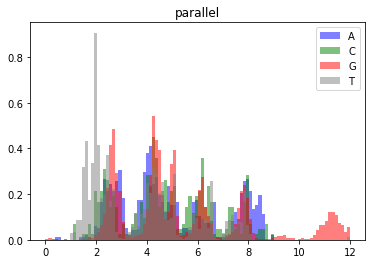

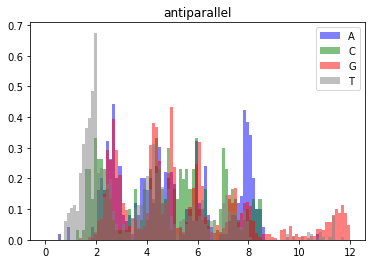

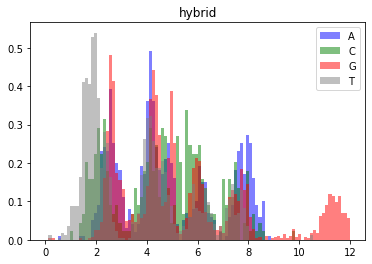


 mean nb of peak in A :7.673058608058608

 mean nb of peak in C :8.064616402116402

 mean nb of peak in G :7.793171326676228

 mean nb of peak in T :9.661339586339587


In [ ]:
plt.figure()
plt.hist(histAp,bins = 100, range = (0,12),density = True,color = "blue",alpha = 0.5, label = 'A')
plt.hist(histCp,bins = 100, range = (0,12),density = True,color = "green",alpha = 0.5, label = 'C')
plt.hist(histGp,bins = 100, range = (0,12),density = True,color = "red",alpha = 0.5, label = 'G')
plt.hist(histTp,bins = 100, range = (0,12),density = True,color = "grey",alpha = 0.5, label = 'T')
plt.title("parallel")
plt.legend()
plt.show()

plt.figure()
plt.hist(histAa,bins = 100, range = (0,12),density = True,color = "blue",alpha = 0.5, label = 'A')
plt.hist(histCa,bins = 100, range = (0,12),density = True,color = "green",alpha = 0.5, label = 'C')
plt.hist(histGa,bins = 100, range = (0,12),density = True,color = "red",alpha = 0.5, label = 'G')
plt.hist(histTa,bins = 100, range = (0,12),density = True,color = "grey",alpha = 0.5, label = 'T')
plt.title("antiparallel")
plt.legend()
plt.show()

plt.figure()
plt.hist(histAh,bins = 100, range = (0,12),density = True,color = "blue",alpha = 0.5, label = 'A')
plt.hist(histCh,bins = 100, range = (0,12),density = True,color = "green",alpha = 0.5, label = 'C')
plt.hist(histGh,bins = 100, range = (0,12),density = True,color = "red",alpha = 0.5, label = 'G')
plt.hist(histTh,bins = 100, range = (0,12),density = True,color = "grey",alpha = 0.5, label = 'T')
plt.title("hybrid")
plt.legend()
plt.show()

nbA = np.mean(nb_nuclA)
nbC = np.mean(nb_nuclC)
nbG = np.mean(nb_nuclG)
nbT = np.mean(nb_nuclT)

print("\n mean nb of peak in A :"+str(np.mean(nbA)))
print("\n mean nb of peak in C :"+str(np.mean(nbC)))
print("\n mean nb of peak in G :"+str(np.mean(nbG)))
print("\n mean nb of peak in T :"+str(np.mean(nbT)))

## On calcule les distrib associées en normalisant

In [ ]:
a = 4
b = 11

nbins = 30

PAp,bins = np.histogram(histAp,bins = np.linspace(a,b,nbins))
PCp,bins = np.histogram(histCp,bins = np.linspace(a,b,nbins))
PGp,bins = np.histogram(histGp,bins = np.linspace(a,b,nbins))
PTp,bins = np.histogram(histTp,bins = np.linspace(a,b,nbins))
PAa,bins = np.histogram(histAa,bins = np.linspace(a,b,nbins))
PCa,bins = np.histogram(histCa,bins = np.linspace(a,b,nbins))
PGa,bins = np.histogram(histGa,bins = np.linspace(a,b,nbins))
PTa,bins = np.histogram(histTa,bins = np.linspace(a,b,nbins))
PAh,bins = np.histogram(histAh,bins = np.linspace(a,b,nbins))
PCh,bins = np.histogram(histCh,bins = np.linspace(a,b,nbins))
PGh,bins = np.histogram(histGh,bins = np.linspace(a,b,nbins))
PTh,bins = np.histogram(histTh,bins = np.linspace(a,b,nbins))
PA, bins = np.histogram(histA,bins = np.linspace(a,b,nbins))
PC, bins = np.histogram(histC,bins = np.linspace(a,b,nbins))
PT, bins = np.histogram(histT,bins = np.linspace(a,b,nbins))

PA2,bins = np.histogram(histAa+histAh,bins = np.linspace(a,b,nbins))
PC2,bins = np.histogram(histCa+histCh,bins = np.linspace(a,b,nbins))
PG2,bins = np.histogram(histGa+histGh,bins = np.linspace(a,b,nbins))
PT2,bins = np.histogram(histTa+histTh,bins = np.linspace(a,b,nbins))

PAp = PAp / np.sum(PAp)
PCp = PCp / np.sum(PCp)
PGp = PGp / np.sum(PGp)
PTp = PTp / np.sum(PTp)
PAa = PAa / np.sum(PAa)
PCa = PCa / np.sum(PCa)
PGa = PGa / np.sum(PGa)
PTa = PTa / np.sum(PTa)
PAh = PAh / np.sum(PAh)
PCh = PCh / np.sum(PCh)
PGh = PGh / np.sum(PGh)
PTh = PTh / np.sum(PTh)
PA = PA/np.sum(PA)
PC = PC/np.sum(PC)
PT = PT/np.sum(PT)

PA2 = PA2/np.sum(PA2)
PC2 = PC2/np.sum(PC2)
PG2 = PG2/np.sum(PG2)
PT2 = PT2/np.sum(PT2)


In [ ]:
def likelihood(X,PAp,PCp,PGp,PTp,PAa,PCa,PGa,PTa,PAh,PCh,PGh,PTh,nA,nC,nG,nT,a,b,nbins):
    distrib, bins = np.histogram(X,bins = np.linspace(a,b,nbins))

    prod0 = 1
    prod1 = 1
    prod2 = 1

    for k in range(nbins-1):
        x = distrib[k]
        if x !=0:
            prod0 = prod0*((nbA*nA*PAp[k]+nbC*nC*PCp[k]+nbG*nG*PGp[k]+nbT*nT*PTp[k])/(nbA*nA+nbC*nC+nbG*nG+nbT*nT))**x
            prod1 = prod1*((nbA*nA*PAa[k]+nbC*nC*PCa[k]+nbG*nG*PGa[k]+nbT*nT*PTa[k])/(nbA*nA+nbC*nC+nbG*nG+nbT*nT))**x
            prod2 = prod2*((nbA*nA*PAh[k]+nbC*nC*PCh[k]+nbG*nG*PGh[k]+nbT*nT*PTh[k])/(nbA*nA+nbC*nC+nbG*nG+nbT*nT))**x
    return np.argmax([prod0,prod1,prod2])

def likelihood_values(X,PAp,PCp,PGp,PTp,PAa,PCa,PGa,PTa,PAh,PCh,PGh,PTh,nA,nC,nG,nT,a,b,nbins):
    distrib, bins = np.histogram(X,bins = np.linspace(a,b,nbins))

    prod0 = 1
    prod1 = 1
    prod2 = 1

    for k in range(nbins-1):
        x = distrib[k]
        if x !=0:
            prod0 = 2*prod0*((nbA*nA*PAp[k]+nbC*nC*PCp[k]+nbG*nG*PGp[k]+nbT*nT*PTp[k])/(nbA*nA+nbC*nC+nbG*nG+nbT*nT))**x
            prod1 = 2*prod1*((nbA*nA*PAa[k]+nbC*nC*PCa[k]+nbG*nG*PGa[k]+nbT*nT*PTa[k])/(nbA*nA+nbC*nC+nbG*nG+nbT*nT))**x
            prod2 = 2*prod2*((nbA*nA*PAh[k]+nbC*nC*PCh[k]+nbG*nG*PGh[k]+nbT*nT*PTh[k])/(nbA*nA+nbC*nC+nbG*nG+nbT*nT))**x
    return [prod0,prod1,prod2]

def likelihood_bis(X,PA,PC,PT,PGp,PGa,PGh,nA,nC,nG,nT,a,b,nbins):
    distrib, bins = np.histogram(X,bins = np.linspace(a,b,nbins))

    prod0 = 1
    prod1 = 1
    prod2 = 1

    for k in range(nbins-1):
        x = distrib[k]
        if x !=0:
            prod0 = prod0*((nbA*nA*PA[k]+nbC*nC*PC[k]+nbG*nG*PGp[k]+nbT*nT*PT[k])/(nbA*nA+nbC*nC+nbG*nG+nbT*nT))**x
            prod1 = prod1*((nbA*nA*PA[k]+nbC*nC*PC[k]+nbG*nG*PGa[k]+nbT*nT*PT[k])/(nbA*nA+nbC*nC+nbG*nG+nbT*nT))**x
            prod2 = prod2*((nbA*nA*PA[k]+nbC*nC*PC[k]+nbG*nG*PGh[k]+nbT*nT*PT[k])/(nbA*nA+nbC*nC+nbG*nG+nbT*nT))**x
    #print([prod0,prod1,prod2])
    return np.argmax([prod0,prod1,prod2])

def likelihood_2(X,PAp,PCp,PGp,PTp,PA2,PC2,PG2,PT2,nA,nC,nG,nT,a,b,nbins):
    distrib, bins = np.histogram(X,bins = np.linspace(a,b,nbins))

    prod0 = 1
    prod1 = 1

    for k in range(nbins-1):
        x = distrib[k]
        if x !=0:
            prod0 = prod0*((nbA*nA*PAp[k]+nbC*nC*PCp[k]+nbG*nG*PGp[k]+nbT*nT*PTp[k])/(nbA*nA+nbC*nC+nbG*nG+nbT*nT))**x
            prod1 = prod1*((nbA*nA*PA2[k]+nbC*nC*PC2[k]+nbG*nG*PG2[k]+nbT*nT*PT2[k])/(nbA*nA+nbC*nC+nbG*nG+nbT*nT))**x
    return np.argmax([prod0,prod1])

accuracy = 0
nb_test = 0


for name in name_data[:nb_train]:
    try:
        g = find_g4(g4_list,name)
        peaks = get_chem_shift(name)
        topo = g.g4.topologie
        nA,nC,nG,nT = nb_base(name)
        topo_predict = likelihood(peaks,PAp,PCp,PGp,PTp,PAa,PCa,PGa,PTa,PAh,PCh,PGh,PTh,nA,nC,nG,nT,a,b,nbins)
        #topo_predict = likelihood_bis(peaks,PA,PC,PT,PGp,PGa,PGh,nA,nC,nG,nT,a,b,nbins)
        #topo_predict = likelihood_2(X,PAp,PCp,PGp,PTp,PA2,PC2,PG2,PT2,nA,nC,nG,nT,a,b,nbins)
        if topo =="parallel":
            label = 0
#         else:
#             label = 1
        elif topo =="antiparallel":
           label = 1
        else:
           label = 2
        print("Prediction: "+str(topo_predict)+"  ;  Real  : "+topo)
        nb_test+=1
        if label == topo_predict:
            accuracy+=1
    except TypeError:
        print("error")

print("Accuracy : "+str(100*accuracy/nb_test))


Prediction: 1  ;  Real  : antiparallel
Prediction: 1  ;  Real  : hybrid
Prediction: 2  ;  Real  : parallel
Prediction: 1  ;  Real  : parallel
Prediction: 1  ;  Real  : parallel
Prediction: 2  ;  Real  : parallel
Prediction: 1  ;  Real  : antiparallel
Prediction: 2  ;  Real  : antiparallel
Prediction: 0  ;  Real  : parallel
Prediction: 0  ;  Real  : parallel
Prediction: 0  ;  Real  : hybrid
Prediction: 0  ;  Real  : hybrid
Prediction: 0  ;  Real  : parallel
Prediction: 0  ;  Real  : parallel
Prediction: 2  ;  Real  : hybrid
Prediction: 2  ;  Real  : hybrid
Prediction: 2  ;  Real  : hybrid
Prediction: 0  ;  Real  : parallel
Prediction: 2  ;  Real  : hybrid
Prediction: 1  ;  Real  : antiparallel
Prediction: 1  ;  Real  : antiparallel
Prediction: 1  ;  Real  : antiparallel
Prediction: 1  ;  Real  : hybrid
Prediction: 2  ;  Real  : hybrid
Prediction: 0  ;  Real  : parallel
Prediction: 0  ;  Real  : parallel
Prediction: 0  ;  Real  : parallel
Prediction: 0  ;  Real  : parallel
Prediction: 0 

Cherchons l'intervalle sur lequel les résultats sont les meilleurs

In [ ]:
topo_list = []
peaks_list = []
nucl_list = []
for name in name_data:
    g = find_g4(g4_list,name)
    topo = g.g4.topologie
    topo_list.append(topo)
    peaks = get_chem_shift(name)
    peaks_list.append(peaks)
    nA,nC,nG,nT = nb_base(name)
    nucl_list.append([nA,nC,nG,nT])

In [ ]:
a_list = [2,3,4,5,6,7,8,9,10,11]
bins_list = [10,20,30,40,50,60]

maxi = 0
amax = 0
bmax = 0
binmax = 0

for a in a_list:
    for k in range(a+1,13):
        for nbins in bins_list:
            print(a,k,nbins)
            PAp,bins = np.histogram(histAp,bins = np.linspace(a,k,nbins))
            PCp,bins = np.histogram(histCp,bins = np.linspace(a,k,nbins))
            PGp,bins = np.histogram(histGp,bins = np.linspace(a,k,nbins))
            PTp,bins = np.histogram(histTp,bins = np.linspace(a,k,nbins))
            PAa,bins = np.histogram(histAa,bins = np.linspace(a,k,nbins))
            PCa,bins = np.histogram(histCa,bins = np.linspace(a,k,nbins))
            PGa,bins = np.histogram(histGa,bins = np.linspace(a,k,nbins))
            PTa,bins = np.histogram(histTa,bins = np.linspace(a,k,nbins))
            PAh,bins = np.histogram(histAh,bins = np.linspace(a,k,nbins))
            PCh,bins = np.histogram(histCh,bins = np.linspace(a,k,nbins))
            PGh,bins = np.histogram(histGh,bins = np.linspace(a,k,nbins))
            PTh,bins = np.histogram(histTh,bins = np.linspace(a,k,nbins))
            PA, bins = np.histogram(histA,bins = np.linspace(a,k,nbins))
            PC, bins = np.histogram(histC,bins = np.linspace(a,k,nbins))
            PT, bins = np.histogram(histT,bins = np.linspace(a,k,nbins))
            if np.sum(PAp)!=0:
                PAp = PAp / np.sum(PAp)
            if np.sum(PCp)!=0:
                PCp = PCp / np.sum(PCp)
            if np.sum(PGp)!=0:
                PGp = PGp / np.sum(PGp)
            if np.sum(PTp)!=0:
                PTp = PTp / np.sum(PTp)
            if np.sum(PAa)!=0:
                PAa = PAa / np.sum(PAa)
            if np.sum(PCa)!=0:
                PCa = PCa / np.sum(PCa)
            if np.sum(PGa)!=0:
                PGa = PGa / np.sum(PGa)
            if np.sum(PTa)!=0:
                PTa = PTa / np.sum(PTa)
            if np.sum(PAh)!=0:
                PAh = PAh / np.sum(PAh)
            if np.sum(PCh)!=0:
                PCh = PCh / np.sum(PCh)
            if np.sum(PGh)!=0:
                PGh = PGh / np.sum(PGh)
            if np.sum(PTh)!=0:
                PTh = PTh / np.sum(PTh)
            if np.sum(PA) != 0:
                PA = PA/np.sum(PA)
            if np.sum(PC) != 0:
                PC = PC/np.sum(PC)
            if np.sum(PT) != 0:
                PT = PT/np.sum(PT)
            accuracy = 0
            nb_test = 0

            for j in range(nb_train):
                try:
                    peaks = peaks_list[j]
                    topo = topo_list[j]
                    nucl = nucl_list[j]
                    nA,nC,nG,nT = nucl[0],nucl[1],nucl[2],nucl[3]
                    topo_predict = likelihood(peaks,PAp,PCp,PGp,PTp,PAa,PCa,PGa,PTa,PAh,PCh,PGh,PTh,nA,nC,nG,nT,a,k,nbins)
                    #topo_predict = likelihood_bis(peaks,PA,PC,PT,PGp,PGa,PGh,nA,nC,nG,nT,a,b,nbins)
                    if topo =="parallel":
                        label = 0
                    elif topo =="antiparallel":
                        label = 1
                    else:
                        label = 2
                    #print("Prediction: "+str(topo_predict)+"  ;  Real  : "+topo)
                    nb_test+=1
                    if label == topo_predict:
                        accuracy+=1
                except TypeError:
                    print("error")
            accuracy = 100*accuracy/nb_test
            if accuracy > maxi:
                maxi = accuracy
                amax = a
                bmax = k
                binmax = nbins

print("Le max d'accuracy est atteint pour a = "+str(amax)+"  ;  b = "+str(bmax)+" et nbins = "+str(binmax)+"   avec une valeur de  "+str(maxi))


2 3 10
2 3 20
2 3 30
2 3 40
2 3 50
2 3 60
2 4 10
2 4 20
2 4 30
2 4 40
2 4 50
2 4 60
2 5 10
2 5 20
2 5 30
2 5 40
2 5 50
2 5 60
2 6 10
2 6 20
2 6 30
2 6 40
2 6 50
2 6 60
2 7 10
2 7 20
2 7 30
2 7 40
2 7 50
2 7 60
2 8 10
2 8 20
2 8 30
2 8 40
2 8 50
2 8 60
2 9 10
2 9 20
2 9 30
2 9 40
2 9 50
2 9 60
2 10 10
2 10 20
2 10 30
2 10 40
2 10 50
2 10 60
2 11 10
2 11 20
2 11 30
2 11 40
2 11 50
2 11 60
2 12 10
2 12 20
2 12 30
2 12 40
2 12 50
2 12 60
3 4 10
3 4 20
3 4 30
3 4 40
3 4 50
3 4 60
3 5 10
3 5 20
3 5 30
3 5 40
3 5 50
3 5 60
3 6 10
3 6 20
3 6 30
3 6 40
3 6 50
3 6 60
3 7 10
3 7 20
3 7 30
3 7 40
3 7 50
3 7 60
3 8 10
3 8 20
3 8 30
3 8 40
3 8 50
3 8 60
3 9 10
3 9 20
3 9 30
3 9 40
3 9 50
3 9 60
3 10 10
3 10 20
3 10 30
3 10 40
3 10 50
3 10 60
3 11 10
3 11 20
3 11 30
3 11 40
3 11 50
3 11 60
3 12 10
3 12 20
3 12 30
3 12 40
3 12 50
3 12 60
4 5 10
4 5 20
4 5 30
4 5 40
4 5 50
4 5 60
4 6 10
4 6 20
4 6 30
4 6 40
4 6 50
4 6 60
4 7 10
4 7 20
4 7 30
4 7 40
4 7 50
4 7 60
4 8 10
4 8 20
4 8 30
4 8 40
4 8 50
4 8 6

In [ ]:
a = 4
b = 10
nbins = 40

PAp,bins = np.histogram(histAp,bins = np.linspace(a,b,nbins))
PCp,bins = np.histogram(histCp,bins = np.linspace(a,b,nbins))
PGp,bins = np.histogram(histGp,bins = np.linspace(a,b,nbins))
PTp,bins = np.histogram(histTp,bins = np.linspace(a,b,nbins))
PAa,bins = np.histogram(histAa,bins = np.linspace(a,b,nbins))
PCa,bins = np.histogram(histCa,bins = np.linspace(a,b,nbins))
PGa,bins = np.histogram(histGa,bins = np.linspace(a,b,nbins))
PTa,bins = np.histogram(histTa,bins = np.linspace(a,b,nbins))
PAh,bins = np.histogram(histAh,bins = np.linspace(a,b,nbins))
PCh,bins = np.histogram(histCh,bins = np.linspace(a,b,nbins))
PGh,bins = np.histogram(histGh,bins = np.linspace(a,b,nbins))
PTh,bins = np.histogram(histTh,bins = np.linspace(a,b,nbins))

PAp = PAp / np.sum(PAp)
PCp = PCp / np.sum(PCp)
PGp = PGp / np.sum(PGp)
PTp = PTp / np.sum(PTp)
PAa = PAa / np.sum(PAa)
PCa = PCa / np.sum(PCa)
PGa = PGa / np.sum(PGa)
PTa = PTa / np.sum(PTa)
PAh = PAh / np.sum(PAh)
PCh = PCh / np.sum(PCh)
PGh = PGh / np.sum(PGh)
PTh = PTh / np.sum(PTh)

def predict_RMN(X):
    return likelihood(X,PAp,PCp,PGp,PTp,PAa,PCa,PGa,PTa,PAh,PCh,PGh,PTh,nA,nC,nG,nT,a,b,nbins)

In [ ]:
# test_list = ["6SX3","7O1H","6GH0","6RS3","6YCV","6TCG","6TC8","5M1L","6SUU","6TR2"]

# for name in test_list:
#     peaks = get_chem_shift(name)
#     print(predict_RMN(peaks))

test_list = name_data[nb_train:]

accuracy = 0
nb_test = 0

for name in test_list:
    try:
        g = find_g4(g4_list,name)
        peaks = get_chem_shift(name)
        topo = g.g4.topologie
        nA,nC,nG,nT = nb_base(name)
        topo_predict = predict_RMN(peaks)
        if topo =="parallel":
            label = 0
        elif topo =="antiparallel":
            label = 1
        else:
            label = 2
        print("Prediction: "+str(topo_predict)+"  ;  Real  : "+topo)
        nb_test+=1
        if label == topo_predict:
            accuracy+=1
    except TypeError:
        print("error")

print("Accuracy : "+str(100*accuracy/nb_test))



Prediction: 0  ;  Real  : parallel
Prediction: 2  ;  Real  : antiparallel
Prediction: 1  ;  Real  : hybrid
Prediction: 1  ;  Real  : parallel
Prediction: 0  ;  Real  : parallel
Prediction: 2  ;  Real  : hybrid
Prediction: 0  ;  Real  : parallel
Prediction: 0  ;  Real  : parallel
Prediction: 2  ;  Real  : hybrid
Prediction: 2  ;  Real  : parallel
Prediction: 1  ;  Real  : hybrid
Prediction: 2  ;  Real  : hybrid
Prediction: 1  ;  Real  : antiparallel
Prediction: 0  ;  Real  : parallel
Prediction: 2  ;  Real  : hybrid
Prediction: 1  ;  Real  : parallel
Prediction: 0  ;  Real  : parallel
Prediction: 0  ;  Real  : parallel
Prediction: 0  ;  Real  : parallel
Prediction: 0  ;  Real  : hybrid
Prediction: 2  ;  Real  : hybrid
Prediction: 1  ;  Real  : antiparallel
Prediction: 1  ;  Real  : parallel
Prediction: 0  ;  Real  : parallel
Prediction: 0  ;  Real  : parallel
Prediction: 1  ;  Real  : antiparallel
Prediction: 2  ;  Real  : antiparallel
Prediction: 1  ;  Real  : parallel
Prediction: 0  ;

=> On obtient des bons résultats : entre 70% et 80% ce qui est satisfaisant pour la classification en 3 classes (plus de 2 fois mieux que l'aléa)

## Erreurs

<ipython-input-58-fe3e98f743b9>:19: RuntimeWarning: invalid value encountered in double_scalars
  prob_ok.append(values[pred]/np.sum(values))
<ipython-input-58-fe3e98f743b9>:21: RuntimeWarning: invalid value encountered in double_scalars
  prob_fail.append(values[pred]/np.sum(values))


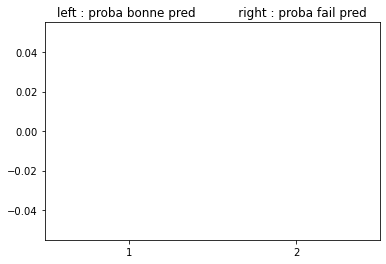

In [ ]:
prob_ok = []
prob_fail = []

for name in test_list:
    try:
        g = find_g4(g4_list,name)
        peaks = get_chem_shift(name)
        topo = g.g4.topologie
        nA,nC,nG,nT = nb_base(name)
        values = likelihood_values(peaks,PAp,PCp,PGp,PTp,PAa,PCa,PGa,PTa,PAh,PCh,PGh,PTh,nA,nC,nG,nT,a,b,nbins)
        pred = np.argmax(values)
        if topo =="parallel":
            label = 0
        elif topo =="antiparallel":
            label = 1
        else:
            label = 2
        if label == topo_predict:
            prob_ok.append(values[pred]/np.sum(values))
        else:
            prob_fail.append(values[pred]/np.sum(values))
    except TypeError:
        print("error")

plt.figure()
plt.boxplot([prob_ok,prob_fail])
plt.title("left : proba bonne pred           right : proba fail pred"   )
plt.show()

## Nouveau dataset : on va focus sur les plages 2-4 et 6.7-8.3


In [ ]:
def get_spectre_focus(name):
    text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+3]!= "1  ":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)


    ind_end = ind_start
    while text[ind_end:ind_end+5]!= "stop_":
        ind_end = following_line(text,ind_end)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')

    peaks1 = []

    peaks2 = []



    for k in range(len(data)):
        peak = data.iloc[k,9]
        if type(peak) != str:
            if 2<peak and peak < 4:
                peaks1.append(peak)
            elif 6.5 < peak and peak < 8.5:
                peaks2.append(peak)

    peaks1 = np.array(peaks1)
    hist1,bins = np.histogram(peaks1,np.linspace(2,4,30))
    peaks2 = np.array(peaks2)
    hist2,bins = np.histogram(peaks2,np.linspace(6.5,8.5,30))
    return np.concatenate((hist1,hist2))

X = []
c = 0
for name in good_g4:
    c+=1
    print(c)
    try:
        hist = get_spectre_focus(name)
        X.append(hist)
    except IndexError:
        print(name)

data_focus = []

for k in range(len(X)):                   #On divise par la masse de chaque échantillon pour avoir une distribution d'histogrammes
    if np.sum(X[k])!=0:     # On trie d'éventuels échantillons vides
        sample = np.concatenate(((X[k]/np.sum(X[k])),[label_g4[k]]))
        data_focus.append(sample)
    else:
        print(k)
data_focus = np.array(data_focus)

np.random.shuffle(data_focus)

np.savetxt('data_focus.txt', data_focus, fmt='%f')   #dataset pour spectre complet avec tous les dép chimiques

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121


Etalement sur la plage 10-12
Infos sur tétrade milieu

## Observons la tétrade du milieu

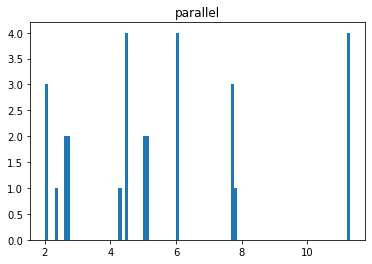

6K3Y


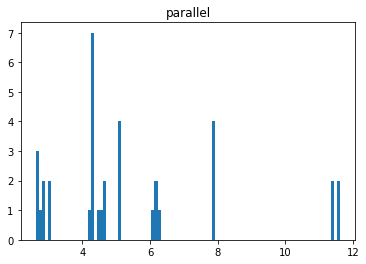

6F4Z


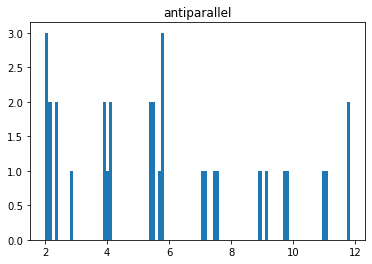

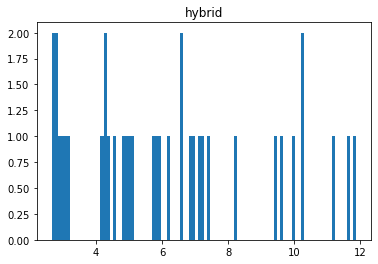

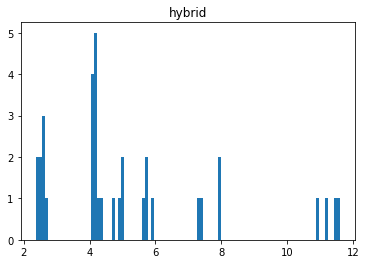

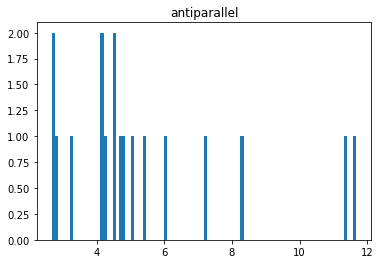

5ZEV


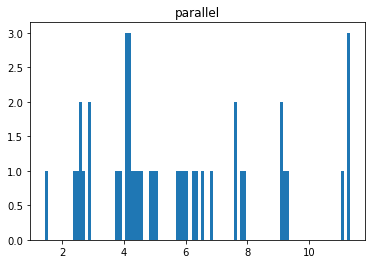

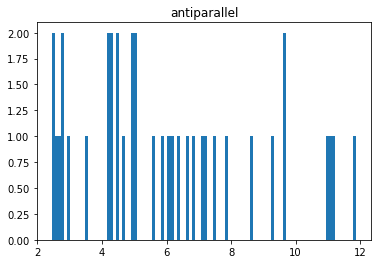

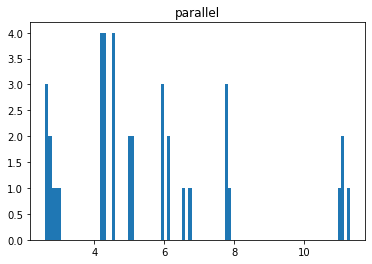

5OV2


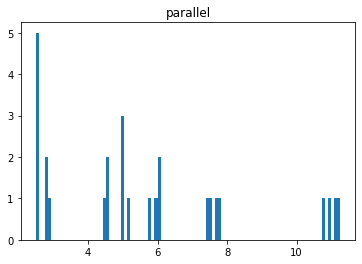

2M1G


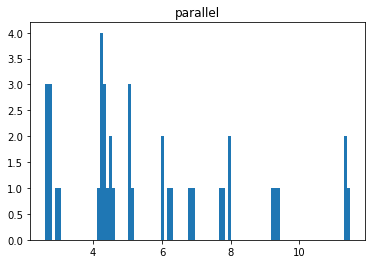

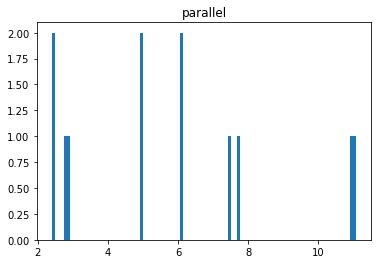

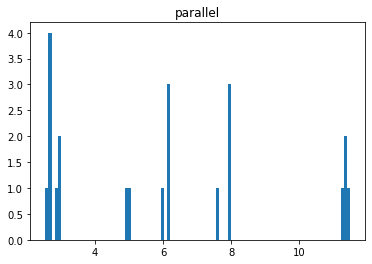

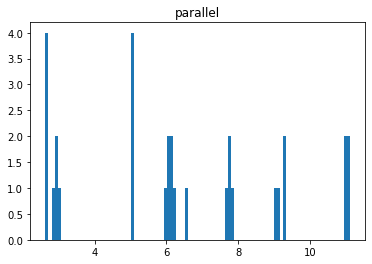

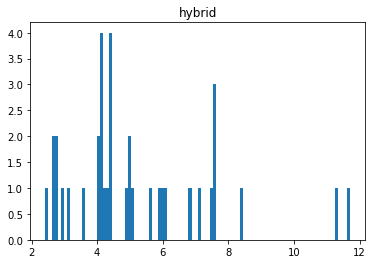

6FC9
2KKA
7CV4
6R9L
2MBJ
5MVB
5MCR
5MBR
6IA4
6IA0
6JCD
6K3Y
6F4Z
5ZEV
5OV2
2M1G
2MCO
2M8Z
2M91
6ERL
2LYG
7CSK
6YEP
5MJX
6GZN
6V0L
2MWZ
2MFU
5J4W
5J4P
2N60
5M2L
2MAY
5LQG
5LQH


In [ ]:
def get_middle_tetrade(name):  #On focus que sur les G des tétrades
    text = urllib.request.urlopen("https://files.rcsb.org/download/"+name+"_cs.str").read().decode()

    def following_line(text,k):
        c = k
        while text[c] != '\n':
            c+=1
        return c+1

    ind_start = 0
    ind_end = 0

    while text[ind_start:ind_start+44]!= "_Atom_chem_shift.Assigned_chem_shift_list_ID":      #on tronque le début du fichier qui ne nous est pas utile pour l'instant
        ind_start = following_line(text,ind_start)

    ind_start = following_line(text,ind_start)

    ind_end = ind_start
    while text[ind_end:ind_end+5]!= "stop_":
        ind_end = following_line(text,ind_end)

    file = StringIO(text[ind_start:ind_end])

    data = pd.read_csv (file, delimiter=" +", header = None,engine = 'python')


    hist = []

    quad = find_g4(g4_list,name)

    if len(quad.g4.t)<3:
        raise NameError('no middle tetrade')

    else:
        middle_t = quad.g4.t[1]
        nb = []
        for g in middle_t:
            nb.append(g.nb)

        for k in range(len(data)):
            if data.iloc[k,3] in nb:
                peak = data.iloc[k,9]
                if 0<peak<12:
                    hist.append(peak)
        return hist, quad.g4.topologie

histp = []
hista = []
histh = []

for name in good_g4[40:60]:
    try:
        h,topo = get_middle_tetrade(name)
        plt.figure()
        plt.hist(h,bins = 100)
        plt.title(topo)
        plt.show()
    except NameError:
        print(name)

for name in good_g4:
    try:
        h,topo = get_middle_tetrade(name)
        if topo == "parallel":
            histp+=h
        elif topo == "antiparallel":
            hista+=h
        else:
            histh+=h
    except NameError:
        print(name)


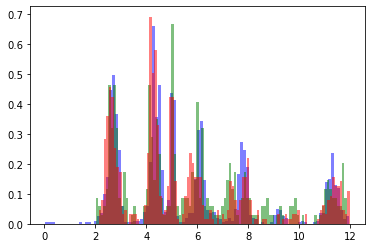

In [ ]:
plt.figure()
plt.hist(histp,bins = 100,density = True, color = "blue",alpha = 0.5)
plt.hist(hista,bins = 100,density = True,color = "green",alpha = 0.5)
plt.hist(histh,bins = 100,density = True,color = "red",alpha = 0.5)
plt.show()

## Missing Data

In [ ]:
missing_g4 = []

for k in range (len(data_g4[0])):
    print(k)
    name = str(data_g4[0][k])
    if not name in good_g4:
        missing_g4.append(name)

np.savetxt("missing_rmn.txt",missing_g4,fmt = '%s')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218


In [ ]:
Topologie('6zx6')


 Tétrade 1 : 
2 (syn)   
10 (anti)   
24 (anti)   
16 (syn)   

 Tétrade 2 : 
3 (anti)   
9 (syn)   
23 (syn)   
17 (anti)   

 Tétrade 3 : 
4 (syn)   
8 (anti)   
22 (anti)   
18 (syn)   

 => antiparallel  (monomeric)

 There is a diagonal loop
